сэмпл обезличенных и данных для работы, кодировка стандартная - utf-8.

Клиенты - юридические лица и ИП. Тип "списание" обозначает, что транзакция от клиента нашего банка * клиенту другого банка, "зачисление" противоположное значение - от клиента другого банка - клиенту нашего банка *. 

Обозначения в колонках достаточно простые, если будет непонятно - пиши. инн изменены.

Рассматриваем только клиентов нашего банка (для них все считать необходимо):

- в случае транзакции типа "списание" - от кого идут деньги ("from")
- в случае транзакции типа "зачисление" - кому идут деньги ("to")

Датасет неполный. 15 дней, не все компании и транзакции.

Необходимо:

1) разобраться в данных

2) выделить клиентов банка

3) для клиентов банка посчитать характеристики входящих и исходящий финансовых потоков (сумма, количество транзакций, количество компаний-партнеров (с кем транзачит) и так далее).

4) кластеризовать клиетов по выделенным характеристикам

Кластеризация в данном случае необходима, чтобы понять, какие кластеры компаний можно выделить в соответствиии с их транзакционной активностью (мелкий бизнес, крупный бизнес, работа с мелкими договорами и т.д.). Тут надо фантазировать.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

In [3]:
df = pd.read_csv('data_sample_06_17.csv')

In [4]:
df.tail()

,summa,transaction_type,company_inn_from,company_inn_to,from_type,to_type,from_inn_region,to_inn_region
812563,14050,списание,156655,108384,ЮЛ,ЮЛ,78,77
812564,12899,списание,130864,169245,ЮЛ,ЮЛ,16,77
812565,30000,списание,118189,49191,ЮЛ,ЮЛ,78,74
812566,2000000,списание,178099,92289,ЮЛ,ЮЛ,78,25
812567,3482871,списание,117423,144602,ЮЛ,ЮЛ,77,52


### Разделяю датасет по типу транзакции, чтобы выиделить наших клиентов

In [5]:
clients_sent = df.loc[(df.transaction_type == 'списание')].rename(columns={'company_inn_from': 'inn'})#.set_index("inn")
clients_sent.head()

,summa,transaction_type,inn,company_inn_to,from_type,to_type,from_inn_region,to_inn_region
0,26150,списание,144897,182381,ЮЛ,ЮЛ,78,77
1,2354,списание,197997,141025,ИП,ЮЛ,78,50
2,449,списание,197997,25474,ИП,ЮЛ,78,50
3,760,списание,197997,25474,ИП,ЮЛ,78,50
4,13714,списание,62379,171735,ИП,ЮЛ,47,77


In [6]:
clients_received = df.loc[(df.transaction_type == 'зачисление')].rename(columns={'company_inn_to': 'inn'})#.set_index("inn")
clients_received.head()

,summa,transaction_type,company_inn_from,inn,from_type,to_type,from_inn_region,to_inn_region
209068,51017,зачисление,195499,35741,ЮЛ,ЮЛ,2,78
209069,58300,зачисление,32291,151272,ЮЛ,ЮЛ,2,78
209070,610,зачисление,156675,94144,ЮЛ,ЮЛ,2,78
209071,34958,зачисление,94947,101867,ЮЛ,ЮЛ,2,78
209072,775,зачисление,164863,94144,ЮЛ,ЮЛ,2,78


### EDA

In [7]:
print(clients_sent.shape)

(468524, 8)


In [8]:
clients_sent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 468524 entries, 0 to 812567
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   summa             468524 non-null  int64 
 1   transaction_type  468524 non-null  object
 2   inn               468524 non-null  int64 
 3   company_inn_to    468524 non-null  int64 
 4   from_type         468524 non-null  object
 5   to_type           468524 non-null  object
 6   from_inn_region   468524 non-null  int64 
 7   to_inn_region     468524 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 32.2+ MB


In [9]:
# missing values
clients_sent.isnull().sum().sort_values(ascending=False)

summa               0
transaction_type    0
inn                 0
company_inn_to      0
from_type           0
to_type             0
from_inn_region     0
to_inn_region       0
dtype: int64

In [10]:
# List of features with missing values

total = clients_sent.isnull().sum().sort_values(ascending=False)
percent = (clients_sent.isnull().sum()/clients_sent.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
summa,0,0.0
transaction_type,0,0.0
inn,0,0.0
company_inn_to,0,0.0
from_type,0,0.0
to_type,0,0.0
from_inn_region,0,0.0
to_inn_region,0,0.0


In [11]:
clients_sent.describe()

,summa,inn,company_inn_to,from_inn_region,to_inn_region
count,4.685240e+05,468524.000000,468524.000000,468524.000000,468524.000000
mean,1.555113e+05,103036.138059,102110.656276,71.541200,69.703928
std,2.829304e+06,57659.530646,55849.973613,14.286382,16.107778
min,0.000000e+00,9.000000,3.000000,2.000000,1.000000
25%,2.824000e+03,54141.000000,56996.000000,78.000000,77.000000
50%,1.095800e+04,105231.000000,100351.000000,78.000000,78.000000
75%,4.971000e+04,152345.000000,146757.000000,78.000000,78.000000
max,1.000000e+09,201795.000000,201788.000000,99.000000,99.000000


In [12]:
numerical_feats = clients_sent.dtypes[clients_sent.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = clients_sent.dtypes[clients_sent.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  5
Number of Categorical features:  3


In [13]:
clients_received.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 344044 entries, 209068 to 809349
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   summa             344044 non-null  int64 
 1   transaction_type  344044 non-null  object
 2   company_inn_from  344044 non-null  int64 
 3   inn               344044 non-null  int64 
 4   from_type         344044 non-null  object
 5   to_type           344044 non-null  object
 6   from_inn_region   344044 non-null  int64 
 7   to_inn_region     344044 non-null  int64 
dtypes: int64(5), object(3)
memory usage: 23.6+ MB


In [14]:
# missing values
clients_received.isnull().sum().sort_values(ascending=False)

summa               0
transaction_type    0
company_inn_from    0
inn                 0
from_type           0
to_type             0
from_inn_region     0
to_inn_region       0
dtype: int64

In [15]:
clients_received.describe()

,summa,company_inn_from,inn,from_inn_region,to_inn_region
count,3.440440e+05,344044.000000,344044.000000,344044.000000,344044.000000
mean,1.648763e+05,100281.075627,104495.487400,65.752160,72.852932
std,2.536272e+06,57499.506758,55664.193254,19.136552,13.036264
min,0.000000e+00,1.000000,9.000000,1.000000,2.000000
25%,3.034000e+03,51251.000000,62485.000000,50.000000,78.000000
50%,1.258900e+04,99450.000000,100570.000000,78.000000,78.000000
75%,5.345400e+04,149479.250000,152157.000000,78.000000,78.000000
max,8.076298e+08,201794.000000,201786.000000,99.000000,99.000000


In [16]:
numerical_feats = clients_received.dtypes[clients_received.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = clients_received.dtypes[clients_received.dtypes == "object"]#.index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  5
Number of Categorical features:  3


In [17]:
numerical_feats

Index(['summa', 'company_inn_from', 'inn', 'from_inn_region', 'to_inn_region'], dtype='object')

In [18]:
clients_received[numerical_feats].head()

,summa,company_inn_from,inn,from_inn_region,to_inn_region
209068,51017,195499,35741,2,78
209069,58300,32291,151272,2,78
209070,610,156675,94144,2,78
209071,34958,94947,101867,2,78
209072,775,164863,94144,2,78


In [19]:
categorical_feats

transaction_type    object
from_type           object
to_type             object
dtype: object

In [20]:
clients_received.from_type.unique() 

array(['ЮЛ', 'ИП'], dtype=object)

In [21]:
clients_received.from_type.describe()

count     344044
unique         2
top           ЮЛ
freq      308664
Name: from_type, dtype: object

In [22]:
clients_received.transaction_type.unique()        

array(['зачисление'], dtype=object)

In [23]:
clients_received.transaction_type.describe()

count         344044
unique             1
top       зачисление
freq          344044
Name: transaction_type, dtype: object

In [24]:
# df.loc[:, ['transaction_type','company_inn_from']]

In [25]:
# clients_received.transaction_type.value_counts()

In [26]:
q_ty_clients_sent=clients_sent.groupby(['inn']).sum().shape[0]
q_ty_clients_sent

27116

In [27]:
clients_sent['from_type'].value_counts()

ЮЛ    441347
ИП     27177
Name: from_type, dtype: int64

In [28]:
q_ty_clients_received=clients_received.groupby(['inn']).sum().shape[0]
q_ty_clients_received

18680

In [29]:
clients_received['from_type'].value_counts()

ЮЛ    308664
ИП     35380
Name: from_type, dtype: int64

In [30]:
# df.loc[(df.transaction_type == 'списание')].groupby(['company_inn_from']).summa.agg([len,sum, min, max]).sort_values(by='len', ascending=False)

#### Distribution of Summa

C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 210.989669
Kurtosis: 61509.245649


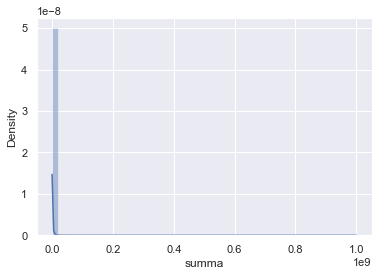

In [31]:
sns.distplot(clients_sent['summa'])

# skewness and kurtosis
print("Skewness: %f" % clients_sent['summa'].skew())
print("Kurtosis: %f" % clients_sent['summa'].kurt())

### Checking for skewness and kurtosis (ассиметрия и эксцесс).
 Like skewness, kurtosis describes the shape of a probability distribution.
  higher kurtosis corresponds to greater extremity of deviations (or outliers), and not the configuration of data near the mean.
  The kurtosis of any univariate normal distribution is 3. It is common to compare the kurtosis of a distribution to this value.
  Distributions with kurtosis less than 3 , it means the distribution produces fewer and less extreme outliers than does the normal distribution. Distributions with kurtosis greater than 3 produces more outliers than the normal distribution.
  It is also common practice to use an adjusted version of Pearson's kurtosis, the excess kurtosis, which is the kurtosis minus 3
  skewness is a measure of the asymmetry.The skewness value can be positive, zero, negative, or undefined.

For a unimodal distribution, negative skew commonly indicates that the tail is on the left side of the distribution, and positive skew indicates that the tail is on the right. In cases where one tail is long but the other tail is fat, skewness does not obey a simple rule. For example, a zero value means that the tails on both sides of the mean balance out overall; this is the case for a symmetric distribution, but can also be true for an asymmetric distribution where one tail is long and thin, and the other is short but fat.

In [32]:
numerical_feats_sent = clients_sent.dtypes[clients_sent.dtypes != "object"].index
for col in numerical_feats_sent:
    print('{:15}'.format(col), 
              'Skewness: {:05.2f}'.format(clients_sent[col].skew()) , 
              '   ' ,
              'Kurtosis: {:06.2f}'.format(clients_sent[col].kurt())  
             )

summa           Skewness: 210.99     Kurtosis: 61509.25
inn             Skewness: -0.07     Kurtosis: -01.18
company_inn_to  Skewness: -0.03     Kurtosis: -01.09
from_inn_region Skewness: -1.87     Kurtosis: 001.98
to_inn_region   Skewness: -1.68     Kurtosis: 001.77


C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -1.872281
Kurtosis: 1.980472


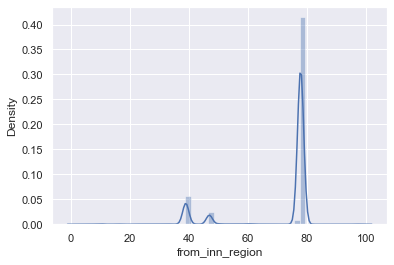

In [33]:
sns.distplot(clients_sent['from_inn_region']);
#skewness and kurtosis
print("Skewness: %f" % clients_sent['from_inn_region'].skew())
print("Kurtosis: %f" % clients_sent['from_inn_region'].kurt())

C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -1.682671
Kurtosis: 1.769156


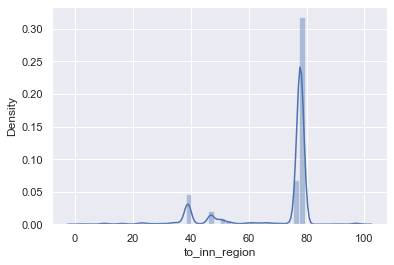

In [34]:
sns.distplot(clients_sent['to_inn_region']);
#skewness and kurtosis
print("Skewness: %f" % clients_sent['to_inn_region'].skew())
print("Kurtosis: %f" % clients_sent['to_inn_region'].kurt())

C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: 156.818489
Kurtosis: 37970.087646


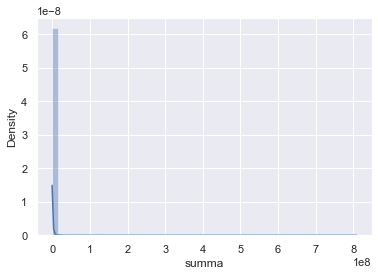

In [35]:
sns.distplot(clients_received['summa'])

# skewness and kurtosis
print("Skewness: %f" % clients_received['summa'].skew())
print("Kurtosis: %f" % clients_received['summa'].kurt())


In [36]:
numerical_feats = clients_received.dtypes[clients_received.dtypes != "object"].index
for col in numerical_feats:
    print('{:15}'.format(col), 
              'Skewness: {:05.2f}'.format(clients_received[col].skew()) , 
              '   ' ,
              'Kurtosis: {:06.2f}'.format(clients_received[col].kurt())  
             )

summa           Skewness: 156.82     Kurtosis: 37970.09
company_inn_from Skewness: 00.02     Kurtosis: -01.17
inn             Skewness: -0.02     Kurtosis: -01.02
from_inn_region Skewness: -1.27     Kurtosis: 000.60
to_inn_region   Skewness: -2.22     Kurtosis: 003.22


C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -1.272759
Kurtosis: 0.603470


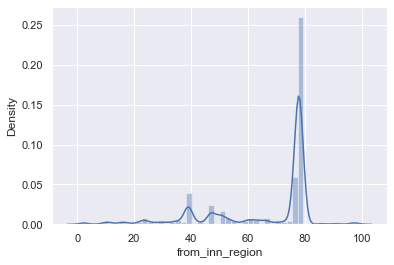

In [37]:
sns.distplot(clients_received['from_inn_region']);
#skewness and kurtosis
print("Skewness: %f" % clients_received['from_inn_region'].skew())
print("Kurtosis: %f" % clients_received['from_inn_region'].kurt())

C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Skewness: -2.220288
Kurtosis: 3.222485


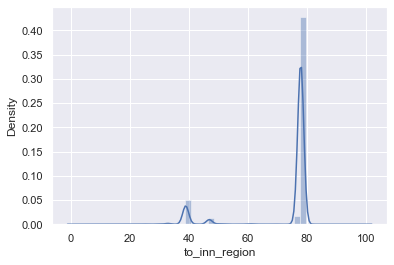

In [38]:
sns.distplot(clients_received['to_inn_region']);
#skewness and kurtosis
print("Skewness: %f" % clients_received['to_inn_region'].skew())
print("Kurtosis: %f" % clients_received['to_inn_region'].kurt())

## Видим, что имеющиеся у нас данные недостаточны для какого либо анализа. Поэтому перейдем к Features Eng.

## Feature Engineering

% платежа среди всех платежей

In [39]:
clients_sent['send_summ_ratio_allpayments'] = (clients_sent['summa']/clients_sent['summa'].sum())*100
# clients_sent.sort_values(by = 'send_summ_ratio_allpayments')

clients_received['received_summ_ratio_allpayments'] = (clients_received['summa']/clients_received['summa'].sum())*100
# clients_received.sort_values(by = 'received_summ_ratio_allpayments')

print(clients_sent.shape,clients_received.shape)

(468524, 9) (344044, 9)


сумма всех транзакций клиента

In [40]:
tmp = clients_sent.groupby('inn')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_sum_inn'})

left = clients_sent.set_index(['inn'])
right = tmp#.set_index(['inn'])

# test = clients_sent
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# print(clients_sent.shape)
# clients_sent.sort_values(by = 'send_sum_inn')


tmp = clients_received.groupby('inn')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_sum_inn'})

left = clients_received.set_index(['inn'])
right = tmp#.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_sent.sort_values(by = 'received_sum_rank_inn')

print(clients_sent.shape,clients_received.shape)

(468524, 9) (344044, 9)


доля всех платежей клиента среди всех платежей

In [41]:
tmp = ((clients_sent.groupby('inn')['send_sum_inn'].max() / clients_sent['summa'].sum())*100).sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'send_sum_inn':'send_sum_inn_ratio'})

left = clients_sent#.set_index(['inn'])
right = tmp#.set_index(['inn'])

# test = clients_sent
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# test = left.join(right, lsuffix='_base', rsuffix='_join')

# test.sort_values(by = 'send_sum_inn_ratio')
# clients_sent.sort_values(by = 'send_sum_inn')

tmp = ((clients_received.groupby('inn')['received_sum_inn'].max() / clients_received['summa'].sum())*100).sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'received_sum_inn':'received_sum_inn_ratio'})

left = clients_received#.set_index(['inn'])
right = tmp#.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_sent.sort_values(by = 'received_sum_inn_ratio')

print(clients_sent.shape,clients_received.shape)

(468524, 10) (344044, 10)


средняя сумма среди всех транзакций клиента

In [42]:
tmp = clients_sent.groupby('inn')['summa'].mean().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_sum_mean_inn'})

left = clients_sent#.set_index(['inn'])
right = tmp #.set_index(['inn'])

# test = clients_sent
# test = test.join(right, lsuffix='_base', rsuffix='_join')
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# test.sort_values(by = 'send_sum_mean_inn')

tmp = clients_received.groupby('inn')['summa'].mean().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_sum_mean_inn'})

left = clients_received#.set_index(['inn'])
right = tmp #.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_sent.sort_values(by = 'received_sum_mean_rank_inn')

print(clients_sent.shape,clients_received.shape)

(468524, 11) (344044, 11)


медианная сумма среди всех транзакций клиента

In [43]:
tmp = clients_sent.groupby('inn')['summa'].median().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_sum_median_inn'})

left = clients_sent#.set_index(['inn'])
right = tmp #.set_index(['inn'])

clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# print(clients_sent.shape)
# clients_sent.sort_values(by = 'send_sum_median_rank_inn')

tmp = clients_received.groupby('inn')['summa'].median().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_sum_median_inn'})

left = clients_received#.set_index(['inn'])
right = tmp #.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# print(clients_sent.shape)
# clients_sent.sort_values(by = 'received_sum_median_rank_inn')

print(clients_sent.shape,clients_received.shape)

(468524, 12) (344044, 12)


количество сделанных платежей клиентом

In [44]:
tmp = clients_sent.groupby('inn')['summa'].count().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_count_inn'})

left = clients_sent#.set_index(['inn'])
right = tmp #.set_index(['inn'])

clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# print(clients_sent.shape)
# clients_sent.sort_values(by = 'send_count_rank_inn')

tmp = clients_received.groupby('inn')['summa'].count().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_count_inn'})
left = clients_received#.set_index(['inn'])
right = tmp #.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_sent.sort_values(by = 'received_count_rank_inn')

print(clients_sent.shape,clients_received.shape)

(468524, 13) (344044, 13)


кому больше всего отправляли наши клиенты по сумме

In [45]:
tmp = clients_sent.groupby('company_inn_to')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'sendto_inn_sum'})

left = clients_sent.reset_index().set_index(['company_inn_to'])#, append=False)
right = tmp #.set_index(['inn'])

clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# print(clients_sent.shape)
# clients_sent.sort_values(by = 'sendto_inn_sum')

tmp = clients_received.groupby('company_inn_from')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_inn_sum'})

left = clients_received.reset_index().set_index(['company_inn_from'])#, append=False)
right = tmp #.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_received.sort_values(by = 'received_inn_sum')

print(clients_sent.shape,clients_received.shape)

(468524, 14) (344044, 14)


кому больше всего отправляли наши клиенты по количеству платежей

In [46]:
tmp = clients_sent.groupby('company_inn_to')['summa'].count().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'sendto_inn_count'})

left = clients_sent.reset_index().set_index(['company_inn_to'])#, append=False)
right = tmp #.set_index(['inn'])

clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# print(clients_sent.shape)
# clients_sent.sort_values(by = 'sendto_inn_count')

tmp = clients_received.groupby('company_inn_from')['summa'].count().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_inn_from_count'})

left = clients_received.reset_index().set_index(['company_inn_from'])#, append=False)
right = tmp #.set_index(['inn'])

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_received.sort_values(by = 'received_inn_from_count')

print(clients_sent.shape,clients_received.shape)

(468524, 15) (344044, 15)


в какой регион больше всего по сумме отправляли клиенты

In [47]:
tmp = clients_sent.groupby('to_inn_region')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'sendto_region_inn_sum'})

left = clients_sent.reset_index().set_index(['to_inn_region'])
right = tmp 
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# print(clients_sent.shape)
# clients_sent.sort_values(by = 'sendto_region_inn_sum')


tmp = clients_received.groupby('to_inn_region')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'sendto_region_inn_sum'})

left = clients_received.reset_index().set_index(['to_inn_region'])
right = tmp 
clients_received = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_received.sort_values(by = 'sendto_region_inn_sum')

print(clients_sent.shape,clients_received.shape)

(468524, 16) (344044, 16)


из какого региона больше всего  по сумме отправляли клиенты

In [48]:
tmp = clients_sent.groupby('from_inn_region')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_from_region_inn_sum'})

left = clients_sent.reset_index().set_index(['from_inn_region'])
right = tmp 
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# print(clients_sent.shape)
# clients_sent.sort_values(by = 'send_from_region_inn_sum')

tmp = clients_received.groupby('from_inn_region')['summa'].sum().sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_from_region_inn_sum'})

left = clients_received.reset_index().set_index(['from_inn_region'])
right = tmp 
clients_received = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_received.sort_values(by = 'send_from_region_inn_sum')

print(clients_sent.shape,clients_received.shape)

(468524, 17) (344044, 17)


In [49]:
# clients_sent.groupby(['inn','from_inn_region'])['from_inn_region'].nunique().sort_values()

In [50]:
tmp = (clients_sent.groupby(['from_inn_region','inn'])['summa'].sum()/ clients_sent.groupby(['from_inn_region'])['summa'].sum())*100
mi = tmp.index
tmp = tmp.reset_index()
tmp = tmp.rename(columns={'summa':'send_from_region_sum_byclient_ratio'})
tmp = tmp.drop(columns = ['from_inn_region'])

left = clients_sent.reset_index().set_index(['inn'])
right = tmp.set_index(['inn']) 
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_sent.sort_values(by = 'send_from_region_sum_byclient_ratio')

tmp = (clients_received.groupby(['to_inn_region','inn'])['summa'].sum()/ clients_received.groupby(['to_inn_region'])['summa'].sum())*100
mi = tmp.index
tmp = tmp.reset_index()
tmp = tmp.rename(columns={'summa':'received_to_region_sum_byclient_ratio'})
tmp = tmp.drop(columns = ['to_inn_region'])

left = clients_received.reset_index().set_index(['inn'])
right = tmp.set_index(['inn']) 
clients_received = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_received.sort_values(by = 'received_to_region_sum_byclient_ratio')


print(clients_sent.shape,clients_received.shape)

(468524, 18) (344044, 18)


In [51]:
# clients_sent.loc[149732].groupby(['from_inn_region'])['from_inn_region'].nunique().sort_values()

In [52]:
# clients_sent.to_inn_region.value_counts()

Доля клиента из региона присутствия банка по сумме всех его платежей

In [53]:
 # не знаю точно все кода регионов
tmp = clients_sent.loc[(clients_sent.from_inn_region.isin([78,77,47,39,54]))]
tmp = ((tmp.groupby('inn')['summa'].sum() / tmp['summa'].sum())*100).sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_sum_home_region_ratio'})

left = clients_sent.reset_index().set_index(['inn'])
right = tmp
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_sent.sort_values(by = 'send_sum_home_region_ratio')

tmp = clients_received.loc[(clients_received.from_inn_region.isin([78,77,47,39,54]))]
tmp = ((tmp.groupby('inn')['summa'].sum() / tmp['summa'].sum())*100).sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_sum_home_region_ratio'})

left = clients_received.reset_index().set_index(['inn'])
right = tmp

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_received.sort_values(by = 'received_sum_home_region_ratio')

print(clients_sent.shape,clients_received.shape)

(468524, 19) (344044, 19)


Доля клиента НЕ из региона присутствия банка по сумме всех его платежей

In [54]:
tmp = clients_sent[clients_sent.from_inn_region.isin([78,77,47,39,54])== False]
tmp = ((tmp.groupby('inn')['summa'].sum() / tmp['summa'].sum())*100).sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'send_sum_another_region_ratio'})

left = clients_sent.reset_index().set_index(['inn'])
right = tmp

clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# print(clients_sent.shape)
# clients_sent.sort_values(by = 'send_sum_another_region_ratio')

tmp = clients_received[clients_received.from_inn_region.isin([78,77,47,39,54])== False]
tmp = ((tmp.groupby('inn')['summa'].sum() / tmp['summa'].sum())*100).sort_values(ascending=False)
tmp = tmp.to_frame()
tmp = tmp.rename(columns={'summa':'received_sum_another_region_ratio'})

left = clients_received.reset_index().set_index(['inn'])
right = tmp

clients_received = left.join(right, lsuffix='_base', rsuffix='_join')

# clients_received.sort_values(by = 'received_sum_another_region_ratio')

print(clients_sent.shape,clients_received.shape)

(468524, 20) (344044, 20)


In [55]:
# tmp.loc[(tmp['from_inn_region'] == 77)]#summa.sum()
# clients_sent.loc[(clients_sent.from_inn_region == 77)].sort_values(by = 'send_from_region_sum_rank_byclient')

In [56]:
# clients_sent.loc[9]
# result.loc[(result.inn == 149732)].summa.sum()

 С какими юр.лицами (доля)по суммме клиенты получали

In [57]:
tmp = (clients_sent.groupby(['from_type','inn'])['summa'].sum()/ clients_sent.groupby(['from_type'])['summa'].sum())*100
mi = tmp.index
tmp = tmp.reset_index()
tmp = tmp.rename(columns={'summa':'send_companytype_sum_ratio'})
tmp = tmp.drop(columns = ['from_type'])
tmp

left = clients_sent.reset_index().set_index(['inn'])
right = tmp.set_index(['inn']) 
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_sent.sort_values(by = 'send_companytype_sum_ratio')

tmp = (clients_received.groupby(['to_type','inn'])['summa'].sum()/ clients_received.groupby(['to_type'])['summa'].sum())*100
mi = tmp.index
tmp = tmp.reset_index()
tmp = tmp.rename(columns={'summa':'received_companytype_sum_ratio'})
tmp = tmp.drop(columns = ['to_type'])

left = clients_received.reset_index().set_index(['inn'])
right = tmp.set_index(['inn']) 
clients_received = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_received.sort_values(by = 'received_companytype_sum_ratio')


print(clients_sent.shape,clients_received.shape)


(468524, 21) (344044, 21)


In [58]:
# tmp = (clients_sent.groupby(['from_type','inn'])['summa'].sum()/ clients_sent.groupby(['inn'])['summa'].sum())*100
# tmp = clients_sent.groupby(['from_type','inn'])['summa'].sum()
# mi = tmp.index
# tmp = tmp.reset_index()
# tmp = tmp.rename(columns={'summa':'send_companytype_sum'})
# # tmp.set_index(['inn'],inplace =True)
# # tmp

# tmp3 = clients_sent.groupby(['inn'])['summa'].sum()
# mi = tmp3.index
# tmp3 = tmp3.reset_index()
# tmp3 = tmp3.rename(columns={'summa':'send_inn_sum'})
# # tmp3

# left = tmp.set_index(['inn'])
# right = tmp3.set_index(['inn']) 
# tmp_tmp3 = left.join(right, lsuffix='_base', rsuffix='_join')
# tmp_tmp3

# tmp_tmp3.loc[tmp_tmp3.from_type == 'ИП','IPratio'] = tmp_tmp3.send_companytype_sum/tmp_tmp3.send_inn_sum
# tmp_tmp3

# # tmp = tmp.drop(columns = ['from_type'])
# tmp2 = clients_sent.groupby(['inn'])['summa'].sum()
# tmp.loc[tmp.from_type == 'ИП','send_companyIP_type_sum_ratio'] = tmp.send_companytype_sum
# #                                                                   clients_sent.groupby(['inn'])['summa'].sum())*100
# # tmp2 = clients_sent.groupby(['inn'])['summa'].sum()
# # tmp['send_companytype_sum_ratio'] = (tmp.send_companytype_sum/clients_sent.groupby(['inn'])['summa'].sum())*100
# # df.loc[df['longitude'] == 0, 'longitude'] = df['longitude'].median()
# tmp3

In [59]:
tmp = clients_received.groupby(['inn','to_type'])['summa'].sum()
mi = tmp.index
tmp = tmp.reset_index()
my_value_count = tmp['inn'].value_counts()
my_value_count.loc[my_value_count !=1]


Series([], Name: inn, dtype: int64)

In [60]:
tmp = clients_sent.groupby(['inn','from_type'])['summa'].sum()
mi = tmp.index
tmp = tmp.reset_index()
my_value_count = tmp['inn'].value_counts()
my_value_count.loc[my_value_count !=1]

Series([], Name: inn, dtype: int64)

#### Получилось, что клиенты получают только от одного типа юридических лиц!!!!

In [61]:
# clients_sent.groupby(['from_type','inn'])['summa'].sum()

 Каким юр.лицам больше всего отправляли,доля, по сумме переводов

In [62]:
tmp = (clients_sent.groupby(['inn','to_type'])['summa'].sum()/clients_sent.groupby(['inn'])['summa'].sum())*100#.sort_values(ascending=False)
mi = tmp.index
tmp = tmp.reset_index()
tmp = tmp.rename(columns={'summa':'send_to_type_ratio'})
tmp.loc[tmp.to_type == 'ИП','send_companyIP_type_sum_ratio'] = tmp.send_to_type_ratio
tmp.loc[tmp.to_type == 'ЮЛ','send_companyLLC_type_sum_ratio'] = tmp.send_to_type_ratio
tmp = tmp.drop(columns = ['to_type'])
tmp

# test = clients_sent
left = clients_sent.reset_index().set_index(['inn'])
right = tmp.set_index(['inn']) 
clients_sent = left.join(right, lsuffix='_base', rsuffix='_join')
# test

tmp = (clients_received.groupby(['inn','from_type'])['summa'].sum()/clients_received.groupby(['inn'])['summa'].sum())*100
mi = tmp.index
tmp = tmp.reset_index()
tmp = tmp.rename(columns={'summa':'received_from_type_ratio'})
tmp.loc[tmp.from_type == 'ИП','received_companyIP_type_sum_ratio'] = tmp.received_from_type_ratio
tmp.loc[tmp.from_type == 'ЮЛ','received_companyLLC_type_sum_ratio'] = tmp.received_from_type_ratio
tmp = tmp.drop(columns = ['from_type'])

left = clients_received.reset_index().set_index(['inn'])
right = tmp.set_index(['inn']) 
clients_received = left.join(right, lsuffix='_base', rsuffix='_join')
# clients_received.sort_values(by = 'received_companytype_sum_ratio')


print(clients_sent.shape,clients_received.shape)


(763727, 24) (589830, 24)


In [63]:
# getting Difference

# comparison_column = np.where(clients_sent['send_from_type_sum_rank_base'] == clients_sent['send_from_type_sum_rank_join'],True, False)
# comparison_column
# clients_sent["equal"] = comparison_column
# clients_sent.loc[clients_sent.equal == False]

In [64]:
# df.loc[(df.transaction_type == 'списание')].groupby(['company_inn_from']).summa.agg([len,sum, min, max]).sort_values(by='len', ascending=False)

#### Обьединяем таблицы

In [65]:

# our_clients
left = clients_sent.reset_index().set_index(['inn'])
right = clients_received.reset_index().set_index(['inn'])

our_clients = pd.concat([clients_sent, clients_received])
# our_clients = left.join(right, lsuffix='_sent', rsuffix='_received')
our_clients

,from_inn_region,to_inn_region,company_inn_to,summa,transaction_type,from_type,to_type,send_summ_ratio_allpayments,send_sum_inn,send_sum_inn_ratio,...,received_count_inn,received_inn_sum,received_inn_from_count,received_to_region_sum_byclient_ratio,received_sum_home_region_ratio,received_sum_another_region_ratio,received_companytype_sum_ratio,received_from_type_ratio,received_companyIP_type_sum_ratio,received_companyLLC_type_sum_ratio
inn,,,,,,,,,,,,,,,,,,,,,
9,78,34,189863.0,800000,списание,ЮЛ,ЮЛ,0.001098,6218112.0,0.008534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78,34,189863.0,2000000,списание,ЮЛ,ЮЛ,0.002745,6218112.0,0.008534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78,34,189863.0,1000000,списание,ЮЛ,ЮЛ,0.001372,6218112.0,0.008534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78,34,189863.0,2000000,списание,ЮЛ,ЮЛ,0.002745,6218112.0,0.008534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,78,78,50243.0,413112,списание,ЮЛ,ЮЛ,0.000567,6218112.0,0.008534,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201782,78,78,NaN,19900,зачисление,ЮЛ,ЮЛ,NaN,NaN,NaN,...,19.0,1868823.0,24.0,0.000535,0.000543,NaN,0.000418,100.0,NaN,100.0
201782,78,78,NaN,10600,зачисление,ЮЛ,ЮЛ,NaN,NaN,NaN,...,19.0,1868823.0,24.0,0.000535,0.000543,NaN,0.000418,100.0,NaN,100.0
201782,78,78,NaN,11000,зачисление,ЮЛ,ЮЛ,NaN,NaN,NaN,...,19.0,1868823.0,24.0,0.000535,0.000543,NaN,0.000418,100.0,NaN,100.0


In [66]:
# my_list = [9]
# our_clients[our_clients.inn.isin(my_list)]


### Аггрегируем все строчки по клиенту

для клиентов банка посчитать характеристики входящих и исходящий финансовых потоков (сумма, количество транзакций, количество компаний-партнеров (с кем транзачит) и так далее).

In [67]:
# list(our_clients.columns)

In [68]:
# оставил только количественные признаки

features = ['summa',
 'send_summ_ratio_allpayments',
 'send_sum_inn',
 'send_sum_inn_ratio',
 'send_sum_mean_inn',
 'send_sum_median_inn',
 'send_count_inn',
 'sendto_inn_sum',
 'sendto_inn_count',
 'sendto_region_inn_sum',
 'send_from_region_inn_sum',
 'send_from_region_sum_byclient_ratio',
 'send_sum_home_region_ratio',
 'send_sum_another_region_ratio',
 'send_companytype_sum_ratio',
 'send_to_type_ratio',
 'send_companyIP_type_sum_ratio',
 'send_companyLLC_type_sum_ratio',
 'company_inn_from',
 'received_summ_ratio_allpayments',
 'received_sum_inn',
 'received_sum_inn_ratio',
 'received_sum_mean_inn',
 'received_sum_median_inn',
 'received_count_inn',
 'received_inn_sum',
 'received_inn_from_count',
 'received_to_region_sum_byclient_ratio',
 'received_sum_home_region_ratio',
 'received_sum_another_region_ratio',
 'received_companytype_sum_ratio',
 'received_from_type_ratio',
 'received_companyIP_type_sum_ratio',
 'received_companyLLC_type_sum_ratio']

In [69]:
our_clients_agg = our_clients[features].groupby(['inn']).agg(['count',sum, min, max,'mean','median'])#.sort_values(by='sum', ascending=False)
our_clients_agg

summa                                                     \
       count       sum    min      max           mean    median   
inn                                                               
9         15  11673713   5000  4515130  778247.533333  132462.0   
26         3     80874   3120    50554   26958.000000   27200.0   
29        24    395772   2442    59712   16490.500000   12850.0   
34        13    225062    600   107539   17312.461538    1676.0   
41         3    341472  24296   244554  113824.000000   72622.0   
...      ...       ...    ...      ...            ...       ...   
201779    10    360530     33   278158   36053.000000    7097.5   
201780    44    541996    574    63140   12318.090909    7116.5   
201782    45    471692      0    54871   10482.044444   10600.0   
201786     3    227500   5500   172000   75833.333333   50000.0   
201795    30    424396     59    81212   14146.533333    2300.0   

       send_summ_ratio_allpayments                                    ...  \
                             count       sum           min       max  ...   
inn                                                                   ...   
9                                6  0.008534  6.862404e-06  0.002745  ...   
26                               1  0.000037  3.733148e-05  0.000037  ...   
29                              24  0.000543  3.351598e-06  0.000082  ...   
34                              13  0.000309  8.234885e-07  0.000148  ...   
41                               3  0.000469  3.334579e-05  0.000336  ...   
...                            ...       ...           ...       ...  ...   
201779                           9  0.000113  4.529187e-08  0.000035  ...   
201780                          43  0.000706  7.878040e-07  0.000087  ...   
201782                          26  0.000329  0.000000e+00  0.000075  ...   
201786                           1  0.000008  7.548645e-06  0.000008  ...   
201795                          30  0.000582  8.097637e-08  0.000111  ...   

       received_companyIP_type_sum_ratio                  \
                                     min max mean median   
inn                                                        
9                                    NaN NaN  NaN    NaN   
26                                   NaN NaN  NaN    NaN   
29                                   NaN NaN  NaN    NaN   
34                                   NaN NaN  NaN    NaN   
41                                   NaN NaN  NaN    NaN   
...                                  ...  ..  ...    ...   
201779                               NaN NaN  NaN    NaN   
201780                               NaN NaN  NaN    NaN   
201782                               NaN NaN  NaN    NaN   
201786                               NaN NaN  NaN    NaN   
201795                               NaN NaN  NaN    NaN   

       received_companyLLC_type_sum_ratio                                      
                                    count     sum    min    max   mean median  
inn                                                                            
9                                       9   900.0  100.0  100.0  100.0  100.0  
26                                      2   200.0  100.0  100.0  100.0  100.0  
29                                      0     0.0    NaN    NaN    NaN    NaN  
34                                      0     0.0    NaN    NaN    NaN    NaN  
41                                      0     0.0    NaN    NaN    NaN    NaN  
...                                   ...     ...    ...    ...    ...    ...  
201779                                  1   100.0  100.0  100.0  100.0  100.0  
201780                                  1   100.0  100.0  100.0  100.0  100.0  
201782                                 19  1900.0  100.0  100.0  100.0  100.0  
201786                                  2   200.0  100.0  100.0  100.0  100.0  
201795                                  0     0.0    NaN    NaN    NaN    NaN  

[28901 rows x 204 columns]

In [70]:
# our_clients_agg_all = our_clients.groupby(['inn']).agg(['count',sum, min, max,'mean','median'])
# our_clients_agg_all

### Заполняю все пропуски нулями

In [71]:
our_clients_agg = our_clients_agg.fillna(0)


In [72]:
our_clients_agg.summa#.iloc[:,0]

,count,sum,min,max,mean,median
inn,,,,,,
9,15,11673713,5000,4515130,778247.533333,132462.0
26,3,80874,3120,50554,26958.000000,27200.0
29,24,395772,2442,59712,16490.500000,12850.0
34,13,225062,600,107539,17312.461538,1676.0
41,3,341472,24296,244554,113824.000000,72622.0
...,...,...,...,...,...,...
201779,10,360530,33,278158,36053.000000,7097.5
201780,44,541996,574,63140,12318.090909,7116.5
201782,45,471692,0,54871,10482.044444,10600.0


In [73]:
# clients_sent.loc[(clients_sent.inn == 149732)].summa.sum()

In [74]:
# our_clients_descibe.len.describe()

In [75]:
# our_clients.groupby(['inn','transaction_type']).summa.agg([len,sum, min, max]).sort_values(by='len', ascending=False)

In [76]:
# my_list = [9]
# our_clients[our_clients.index.isin(my_list)]



#### Standardize summa

In [77]:
X = our_clients_agg.summa

# Standardize
original_data = X#.loc[:, features]
stdzed_data = (original_data - original_data.mean(axis=0)) / original_data.std(axis=0)
stdzed_data


,count,sum,min,max,mean,median
inn,,,,,,
9,-0.059435,0.067267,-0.029374,0.285133,0.271433,0.039900
26,-0.081839,-0.091386,-0.031331,-0.090280,-0.053850,-0.038484
29,-0.042632,-0.087077,-0.032037,-0.089510,-0.058382,-0.049170
34,-0.063169,-0.089413,-0.033954,-0.085488,-0.058026,-0.057491
41,-0.081839,-0.087820,-0.009291,-0.073967,-0.016240,-0.004661
...,...,...,...,...,...,...
201779,-0.068770,-0.087559,-0.034544,-0.071141,-0.049912,-0.053454
201780,-0.005292,-0.085075,-0.033981,-0.089222,-0.060189,-0.053440
201782,-0.003425,-0.086038,-0.034578,-0.089917,-0.060984,-0.050846


C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fu

Skewness: 102.951258
Kurtosis: 12384.487046
Skewness: 64.583323
Kurtosis: 5703.177714
Skewness: 79.787133
Kurtosis: 7735.113085
Skewness: 55.142290
Kurtosis: 3840.168742


C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fu

Skewness: 89.563350
Kurtosis: 10023.588471
Skewness: 65.073724
Kurtosis: 4983.959503


C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


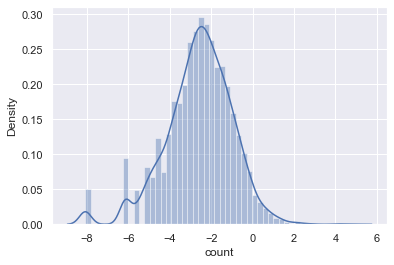

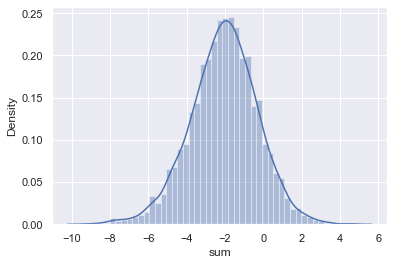

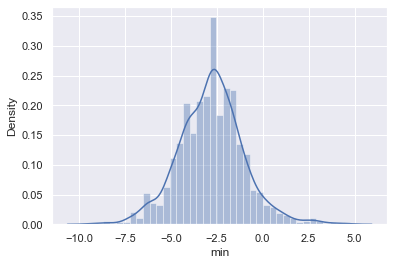

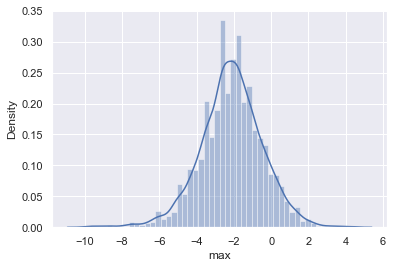

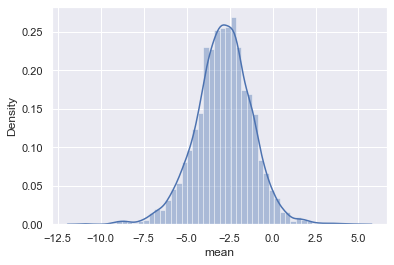

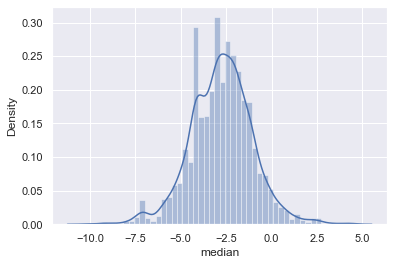

In [78]:
for i in range(stdzed_data.shape[1]):
    plt.figure()
    sns.distplot(np.log(stdzed_data.iloc[:,i]))
    #skewness and kurtosis
    print("Skewness: %f" % stdzed_data.iloc[:,i].skew())
    print("Kurtosis: %f" % stdzed_data.iloc[:,i].kurt())#### Standardize


    
#     plt.hist(np.log(our_clients_agg.summa.iloc[:,i]), bins=100)
#     plt.gca().set(title='Frequency Histogram', ylabel=our_clients_agg.summa.iloc[:,i].name);
# plt.show()



### логарифмирование не получается, слишком много нулей

In [79]:
# поиск бесконечностей
for i in range(our_clients_agg.summa.shape[1]):
    print(np.isinf(np.log(our_clients_agg.summa.iloc[:,i])).sum())

0
14
594
14
14
19


C:\Users\alexl\anaconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


####   подсчет уникальных контрагентов

In [80]:
# our_clients['nuniqe'] = our_clients.groupby(['inn','transaction_type'])['company_inn_to'].transform('nunique')
# our_clients.head()

In [81]:
# our_clients['nuniqe2'] = our_clients.groupby(['inn','transaction_type'])['company_inn_from'].transform('nunique')
# our_clients.tail()

In [82]:
# our_clients = our_clients.rename(columns={'nuniqe': 'q-ty_of_writeoff_client','nuniqe2': 'q-ty_of_senders'})
# our_clients.tail()

In [83]:
# our_clients = our_clients.drop(['q-ty of senders','q-ty of receivers'], axis=1)


In [84]:
# our_clients_descibe = our_clients.groupby(['inn','transaction_type','q-ty_of_senders','q-ty_of_writeoff_client']).summa.agg(['count',sum, min, max,'mean','median'])#.sort_values(by='len', ascending=False)
# our_clients_descibe

### log transform summa

As we see, the variable ['summa'] is not normally distributed.
Therfore we make a log transformation, the resulting distribution looks much better.

<ipython-input-85-3a2113083318>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clients_sent_not0['Summa_Log'] = np.log(clients_sent_not0['summa'])


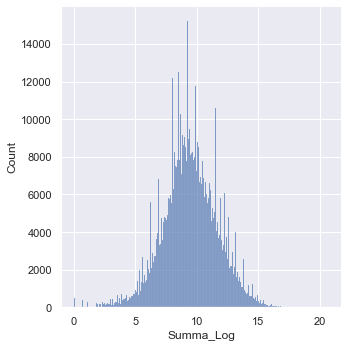

In [85]:
clients_sent_not0= clients_sent.loc[(clients_sent['summa']!=0)]
# clients_sent_not0
clients_sent_not0['Summa_Log'] = np.log(clients_sent_not0['summa'])
clients_sent_not0

sns.displot(clients_sent_not0['Summa_Log'])  

# x = clients_sent_not0['Summa_Log'] 
# plt.hist(x, bins=200)
# plt.gca().set(title='Frequency Histogram', ylabel='Frequency');

C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Summa_Log', ylabel='Density'>

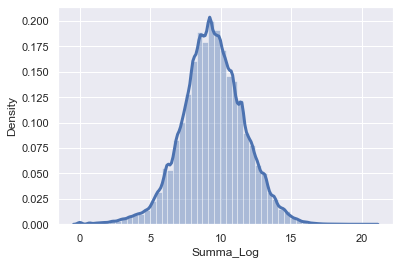

In [86]:
sns.distplot(clients_sent_not0['Summa_Log'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3})

<ipython-input-87-4347813be8cb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clients_received_not0['Summa_Log'] = np.log(clients_received_not0['summa'])


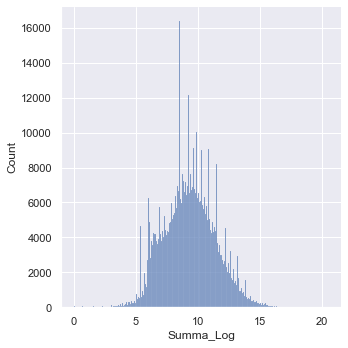

In [87]:
clients_received_not0= clients_received.loc[(clients_received['summa']!=0)]
clients_received_not0['Summa_Log'] = np.log(clients_received_not0['summa'])

sns.displot(clients_received_not0['Summa_Log'])


C:\Users\alexl\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Summa_Log', ylabel='Density'>

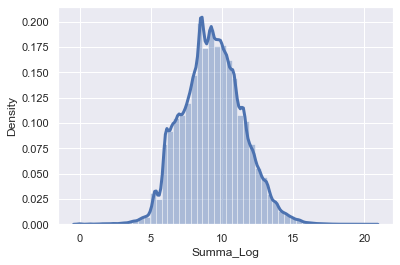

In [88]:
sns.distplot(clients_received_not0['Summa_Log'], hist = True, kde = True,
                 kde_kws = {'linewidth': 3})

In [89]:
# поиск бесконечностей
np.isinf(clients_sent_not0['Summa_Log']).sum()

0

#### Standardize all

In [90]:
X = our_clients_agg

# Standardize
original_data = X#.loc[:, features]
stdzed_data = (original_data - original_data.mean(axis=0)) / original_data.std(axis=0)
stdzed_data

summa                                                    \
           count       sum       min       max      mean    median   
inn                                                                  
9      -0.059435  0.067267 -0.029374  0.285133  0.271433  0.039900   
26     -0.081839 -0.091386 -0.031331 -0.090280 -0.053850 -0.038484   
29     -0.042632 -0.087077 -0.032037 -0.089510 -0.058382 -0.049170   
34     -0.063169 -0.089413 -0.033954 -0.085488 -0.058026 -0.057491   
41     -0.081839 -0.087820 -0.009291 -0.073967 -0.016240 -0.004661   
...          ...       ...       ...       ...       ...       ...   
201779 -0.068770 -0.087559 -0.034544 -0.071141 -0.049912 -0.053454   
201780 -0.005292 -0.085075 -0.033981 -0.089222 -0.060189 -0.053440   
201782 -0.003425 -0.086038 -0.034578 -0.089917 -0.060984 -0.050846   
201786 -0.081839 -0.089379 -0.028854 -0.080068 -0.032689 -0.021506   
201795 -0.031430 -0.086685 -0.034517 -0.087702 -0.059397 -0.057026   

       send_summ_ratio_allpayments                                ...  \
                             count       sum       min       max  ...   
inn                                                               ...   
9                        -0.264197  0.037943 -0.022692  0.135439  ...   
26                       -0.328870 -0.075130 -0.002099 -0.070764  ...   
29                       -0.031374 -0.068399 -0.025065 -0.067366  ...   
34                       -0.173655 -0.071517 -0.026774 -0.062367  ...   
41                       -0.303001 -0.069390 -0.004793 -0.048046  ...   
...                            ...       ...       ...       ...  ...   
201779                   -0.225393 -0.074123 -0.027300 -0.070934  ...   
201780                    0.214383 -0.066230 -0.026798 -0.067007  ...   
201782                   -0.005505 -0.071246 -0.027330 -0.067872  ...   
201786                   -0.328870 -0.075527 -0.022228 -0.073032  ...   
201795                    0.046233 -0.067876 -0.027276 -0.065118  ...   

       received_companyIP_type_sum_ratio                                \
                                     min       max      mean    median   
inn                                                                      
9                              -0.286994 -0.286994 -0.286994 -0.286994   
26                             -0.286994 -0.286994 -0.286994 -0.286994   
29                             -0.286994 -0.286994 -0.286994 -0.286994   
34                             -0.286994 -0.286994 -0.286994 -0.286994   
41                             -0.286994 -0.286994 -0.286994 -0.286994   
...                                  ...       ...       ...       ...   
201779                         -0.286994 -0.286994 -0.286994 -0.286994   
201780                         -0.286994 -0.286994 -0.286994 -0.286994   
201782                         -0.286994 -0.286994 -0.286994 -0.286994   
201786                         -0.286994 -0.286994 -0.286994 -0.286994   
201795                         -0.286994 -0.286994 -0.286994 -0.286994   

       received_companyLLC_type_sum_ratio                                \
                                    count       sum       min       max   
inn                                                                       
9                               -0.011029 -0.007975  0.858775  0.858775   
26                              -0.038089 -0.036179  0.858775  0.858775   
29                              -0.045820 -0.044237 -1.243143 -1.243143   
34                              -0.045820 -0.044237 -1.243143 -1.243143   
41                              -0.045820 -0.044237 -1.243143 -1.243143   
...                                   ...       ...       ...       ...   
201779                          -0.041955 -0.040208  0.858775  0.858775   
201780                          -0.041955 -0.040208  0.858775  0.858775   
201782                           0.027629  0.032315  0.858775  0.858775   
201786                          -0.038089 -0.036179  0.858775  0.85877

#### 1.2 Relation of features in summa

In [91]:
# our_clients_agg_sum[('summa', 'sum')]

In [92]:
our_clients_agg_sum = our_clients[features].groupby(['inn']).agg([sum])
list(our_clients_agg_sum.columns)


[('summa', 'sum'),
 ('send_summ_ratio_allpayments', 'sum'),
 ('send_sum_inn', 'sum'),
 ('send_sum_inn_ratio', 'sum'),
 ('send_sum_mean_inn', 'sum'),
 ('send_sum_median_inn', 'sum'),
 ('send_count_inn', 'sum'),
 ('sendto_inn_sum', 'sum'),
 ('sendto_inn_count', 'sum'),
 ('sendto_region_inn_sum', 'sum'),
 ('send_from_region_inn_sum', 'sum'),
 ('send_from_region_sum_byclient_ratio', 'sum'),
 ('send_sum_home_region_ratio', 'sum'),
 ('send_sum_another_region_ratio', 'sum'),
 ('send_companytype_sum_ratio', 'sum'),
 ('send_to_type_ratio', 'sum'),
 ('send_companyIP_type_sum_ratio', 'sum'),
 ('send_companyLLC_type_sum_ratio', 'sum'),
 ('company_inn_from', 'sum'),
 ('received_summ_ratio_allpayments', 'sum'),
 ('received_sum_inn', 'sum'),
 ('received_sum_inn_ratio', 'sum'),
 ('received_sum_mean_inn', 'sum'),
 ('received_sum_median_inn', 'sum'),
 ('received_count_inn', 'sum'),
 ('received_inn_sum', 'sum'),
 ('received_inn_from_count', 'sum'),
 ('received_to_region_sum_byclient_ratio', 'sum'),
 ('re

In [93]:
original_data = our_clients_agg_sum
stdzed_data_sum = (original_data - original_data.mean(axis=0)) / original_data.std(axis=0)
stdzed_data_sum

,summa,send_summ_ratio_allpayments,send_sum_inn,send_sum_inn_ratio,send_sum_mean_inn,send_sum_median_inn,send_count_inn,sendto_inn_sum,sendto_inn_count,sendto_region_inn_sum,...,received_count_inn,received_inn_sum,received_inn_from_count,received_to_region_sum_byclient_ratio,received_sum_home_region_ratio,received_sum_another_region_ratio,received_companytype_sum_ratio,received_from_type_ratio,received_companyIP_type_sum_ratio,received_companyLLC_type_sum_ratio
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,...,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
inn,,,,,,,,,,,,,,,,,,,,,
9,0.067267,0.037943,-0.013126,-0.013126,0.037943,0.501799,-0.044930,-0.184029,-0.439434,-0.040801,...,-0.008455,0.276692,-0.007655,-0.017005,-0.009991,-0.007097,-0.009876,-0.011227,-0.067077,-0.007975
26,-0.091386,-0.075130,-0.013515,-0.013515,-0.075130,-0.106550,-0.045390,-0.397933,-0.480518,-0.056791,...,-0.008460,-0.055971,-0.009667,-0.017091,-0.010291,-0.007097,-0.010033,-0.038288,-0.067077,-0.036179
29,-0.087077,-0.068399,-0.013466,-0.013466,-0.068399,-0.074711,-0.041620,0.040187,0.410859,-0.024897,...,-0.008460,-0.057509,-0.009873,-0.017091,-0.010292,-0.007097,-0.010033,-0.046019,-0.067077,-0.044237
34,-0.089413,-0.071517,-0.013485,-0.013485,-0.071517,-0.107163,-0.043183,-0.146410,0.135252,-0.044172,...,-0.008460,-0.057509,-0.009873,-0.017091,-0.010292,-0.007097,-0.010033,-0.046019,-0.067077,-0.044237
41,-0.087820,-0.069390,-0.013505,-0.013505,-0.069390,-0.084962,-0.045285,-0.304048,-0.387384,-0.058158,...,-0.008460,-0.057509,-0.009873,-0.017091,-0.010292,-0.007097,-0.010033,-0.046019,-0.067077,-0.044237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201779,-0.087559,-0.074123,-0.013508,-0.013508,-0.074123,-0.103516,-0.044339,-0.244028,-0.111615,-0.046654,...,-0.008460,-0.057339,-0.009865,-0.017090,-0.010292,-0.007096,-0.010032,-0.042153,-0.067077,-0.040208
201780,-0.085075,-0.066230,-0.013284,-0.013284,-0.066230,-0.075797,-0.021113,0.171361,-0.220294,-0.009063,...,-0.008460,-0.057482,-0.009858,-0.017091,-0.010292,-0.007097,-0.010033,-0.042153,-0.067077,-0.040208


C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexl\anacond

C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\alexl\anacond

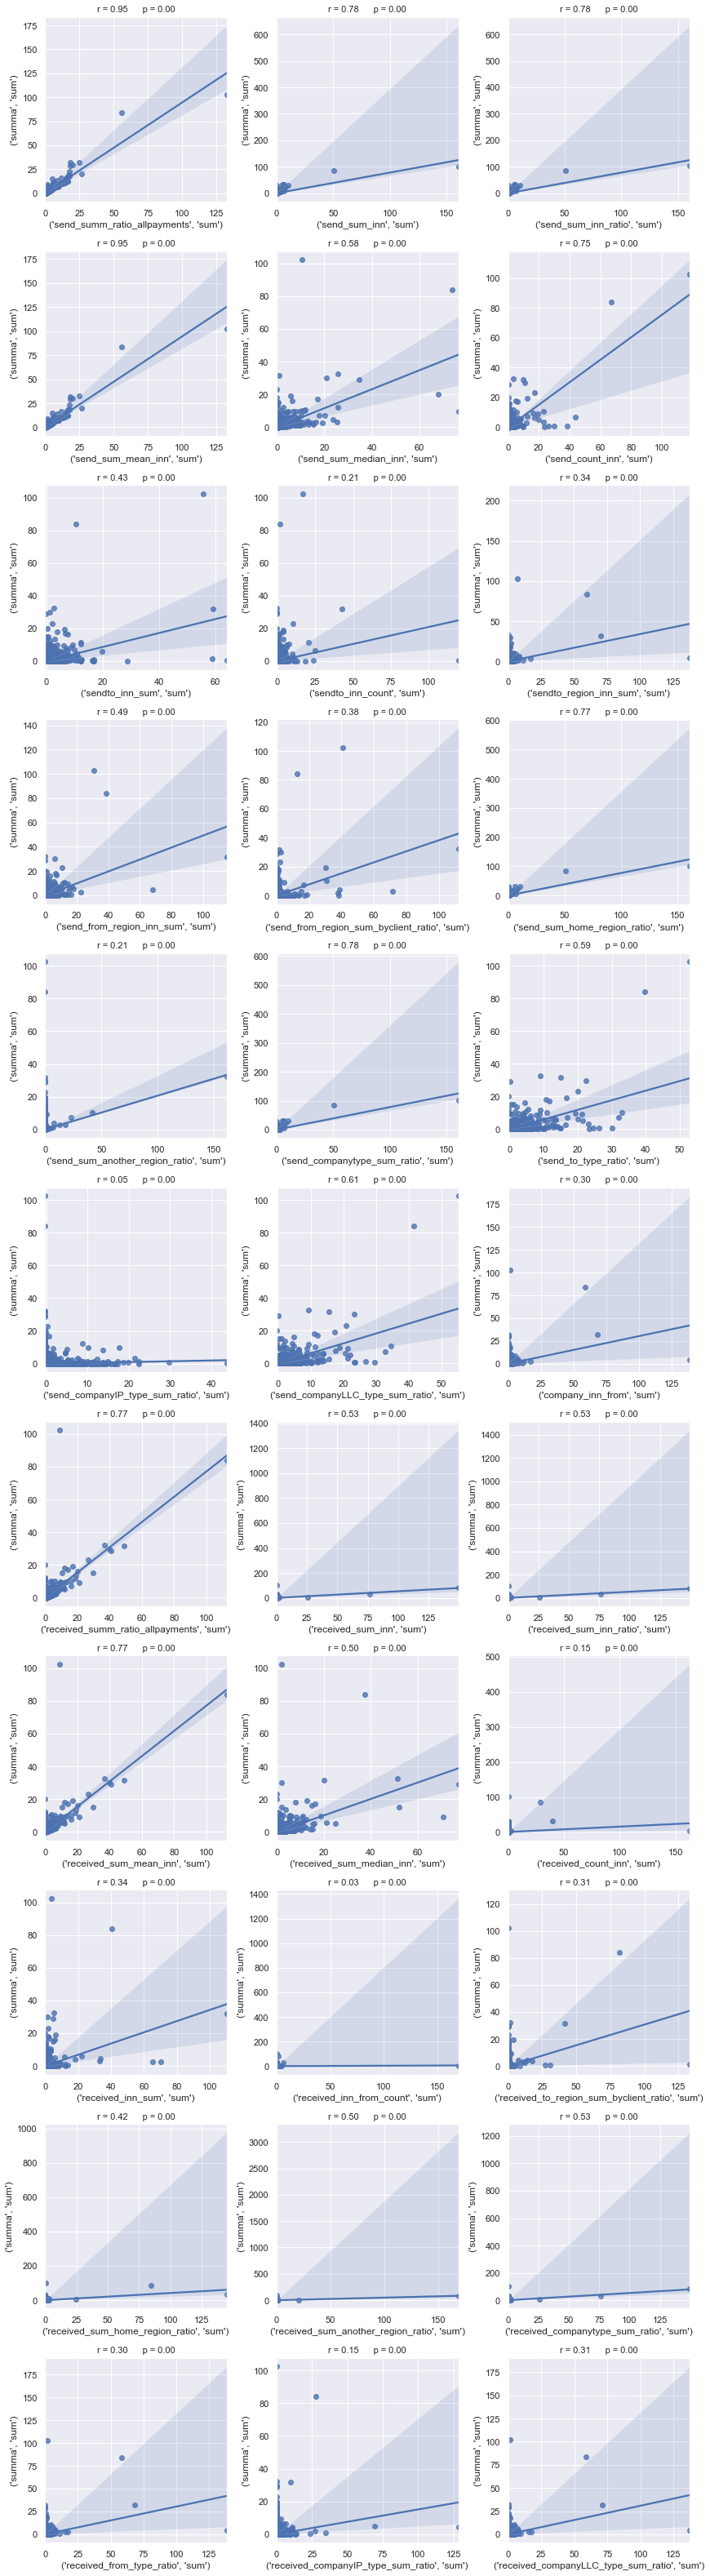

In [95]:
target = ('summa', 'sum')
df = stdzed_data_sum
# numerical_feats = df.dtypes[df.dtypes != "object"].index

features = [ ('send_summ_ratio_allpayments', 'sum'),
 ('send_sum_inn', 'sum'),
 ('send_sum_inn_ratio', 'sum'),
 ('send_sum_mean_inn', 'sum'),
 ('send_sum_median_inn', 'sum'),
 ('send_count_inn', 'sum'),
 ('sendto_inn_sum', 'sum'),
 ('sendto_inn_count', 'sum'),
 ('sendto_region_inn_sum', 'sum'),
 ('send_from_region_inn_sum', 'sum'),
 ('send_from_region_sum_byclient_ratio', 'sum'),
 ('send_sum_home_region_ratio', 'sum'),
 ('send_sum_another_region_ratio', 'sum'),
 ('send_companytype_sum_ratio', 'sum'),
 ('send_to_type_ratio', 'sum'),
 ('send_companyIP_type_sum_ratio', 'sum'),
 ('send_companyLLC_type_sum_ratio', 'sum'),
 ('company_inn_from', 'sum'),
 ('received_summ_ratio_allpayments', 'sum'),
 ('received_sum_inn', 'sum'),
 ('received_sum_inn_ratio', 'sum'),
 ('received_sum_mean_inn', 'sum'),
 ('received_sum_median_inn', 'sum'),
 ('received_count_inn', 'sum'),
 ('received_inn_sum', 'sum'),
 ('received_inn_from_count', 'sum'),
 ('received_to_region_sum_byclient_ratio', 'sum'),
 ('received_sum_home_region_ratio', 'sum'),
 ('received_sum_another_region_ratio', 'sum'),
 ('received_companytype_sum_ratio', 'sum'),
 ('received_from_type_ratio', 'sum'),
 ('received_companyIP_type_sum_ratio', 'sum'),
 ('received_companyLLC_type_sum_ratio', 'sum')]

nr_cols = 3
nr_rows = int(len(features)/nr_cols)


fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*4))

# li_num_feats = list(numerical_feats)
# li_not_plot = ['inn']
# li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]
li_plot_num_feats = features

for r in range(0,nr_rows):
    for c in range(0,nr_cols):  
        i = r*nr_cols+c
        if i < len(li_plot_num_feats):
            sns.regplot(df[li_plot_num_feats[i]], df[target], ax = axs[r][c])
            stp = stats.pearsonr(df[li_plot_num_feats[i]], df[target])
            #axs[r][c].text(0.4,0.9,"title",fontsize=7)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title,fontsize=11)
            
plt.tight_layout()    
plt.show()

#### Find columns with strong correlation to target

List of numerical features and their correlation coefficient to target

In [96]:
# only columns with correlation above this threshold value  
# are used for the ML Regressors
min_val_corr = 0.4 

target = ('summa', 'sum')
df = stdzed_data_sum

corr = df.corr()
corr_abs = corr.abs()

nr_num_cols = len(features)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

print(ser_corr)
print("*"*30)
print("List of numerical features with r above min_val_corr :")
print(cols_abv_corr_limit)
print("*"*30)
print("List of numerical features with r below min_val_corr :")
print(cols_bel_corr_limit)

summa                                  sum    1.000000
send_summ_ratio_allpayments            sum    0.947468
send_sum_mean_inn                      sum    0.947468
send_sum_inn                           sum    0.778820
send_sum_inn_ratio                     sum    0.778820
send_companytype_sum_ratio             sum    0.778639
send_sum_home_region_ratio             sum    0.772440
received_sum_mean_inn                  sum    0.770908
received_summ_ratio_allpayments        sum    0.770908
send_count_inn                         sum    0.752353
send_companyLLC_type_sum_ratio         sum    0.606859
send_to_type_ratio                     sum    0.588735
send_sum_median_inn                    sum    0.579102
received_companytype_sum_ratio         sum    0.529166
received_sum_inn_ratio                 sum    0.529160
received_sum_inn                       sum    0.529160
received_sum_median_inn                sum    0.501365
received_sum_another_region_ratio      sum    0.496586
send_from_

List of categorical features and their unique values

In [97]:
list(our_clients.columns)

['from_inn_region',
 'to_inn_region',
 'company_inn_to',
 'summa',
 'transaction_type',
 'from_type',
 'to_type',
 'send_summ_ratio_allpayments',
 'send_sum_inn',
 'send_sum_inn_ratio',
 'send_sum_mean_inn',
 'send_sum_median_inn',
 'send_count_inn',
 'sendto_inn_sum',
 'sendto_inn_count',
 'sendto_region_inn_sum',
 'send_from_region_inn_sum',
 'send_from_region_sum_byclient_ratio',
 'send_sum_home_region_ratio',
 'send_sum_another_region_ratio',
 'send_companytype_sum_ratio',
 'send_to_type_ratio',
 'send_companyIP_type_sum_ratio',
 'send_companyLLC_type_sum_ratio',
 'company_inn_from',
 'received_summ_ratio_allpayments',
 'received_sum_inn',
 'received_sum_inn_ratio',
 'received_sum_mean_inn',
 'received_sum_median_inn',
 'received_count_inn',
 'received_inn_sum',
 'received_inn_from_count',
 'received_to_region_sum_byclient_ratio',
 'received_sum_home_region_ratio',
 'received_sum_another_region_ratio',
 'received_companytype_sum_ratio',
 'received_from_type_ratio',
 'received_compa

In [98]:
df = our_clients
# categorical_feats = df.dtypes[df.dtypes == "object"].index

categorical_feats = ['from_inn_region',
 'to_inn_region',
 'company_inn_to','company_inn_from',
 'transaction_type',
 'from_type',
 'to_type']

df[categorical_feats]


,from_inn_region,to_inn_region,company_inn_to,company_inn_from,transaction_type,from_type,to_type
inn,,,,,,,
9,78,34,189863.0,NaN,списание,ЮЛ,ЮЛ
9,78,34,189863.0,NaN,списание,ЮЛ,ЮЛ
9,78,34,189863.0,NaN,списание,ЮЛ,ЮЛ
9,78,34,189863.0,NaN,списание,ЮЛ,ЮЛ
9,78,78,50243.0,NaN,списание,ЮЛ,ЮЛ
...,...,...,...,...,...,...,...
201782,78,78,NaN,197948.0,зачисление,ЮЛ,ЮЛ
201782,78,78,NaN,197948.0,зачисление,ЮЛ,ЮЛ
201782,78,78,NaN,197948.0,зачисление,ЮЛ,ЮЛ


In [99]:
df = our_clients
# categorical_feats = df.dtypes[df.dtypes == "object"].index

categorical_feats = ['from_inn_region',
 'to_inn_region',
 'company_inn_to','company_inn_from',
 'transaction_type',
 'from_type',
 'to_type']

for catg in categorical_feats:#list(categorical_feats) :
    print(df[catg].value_counts())
    print('#'*50)

78    899169
39    132819
77     79417
47     62727
50     17728
       ...  
88        16
80        10
81        10
85         9
82         6
Name: from_inn_region, Length: 93, dtype: int64
##################################################
78    948884
39    129851
77    123369
47     43342
50     15112
       ...  
87        15
81         8
79         5
80         2
82         2
Name: to_inn_region, Length: 91, dtype: int64
##################################################
92696.0     18490
127816.0    13972
126289.0     9505
62840.0      9384
27583.0      9041
            ...  
20143.0         1
18535.0         1
103883.0        1
86814.0         1
97038.0         1
Name: company_inn_to, Length: 78729, dtype: int64
##################################################
78851.0     6611
124310.0    2039
70395.0     1586
173323.0    1372
56527.0     1176
            ... 
154191.0       1
54389.0        1
46610.0        1
50907.0        1
182512.0       1
Name: company_inn_from, Length: 

### Features with largest correlation to Target
all numerical features(# with correlation coefficient above threshold)

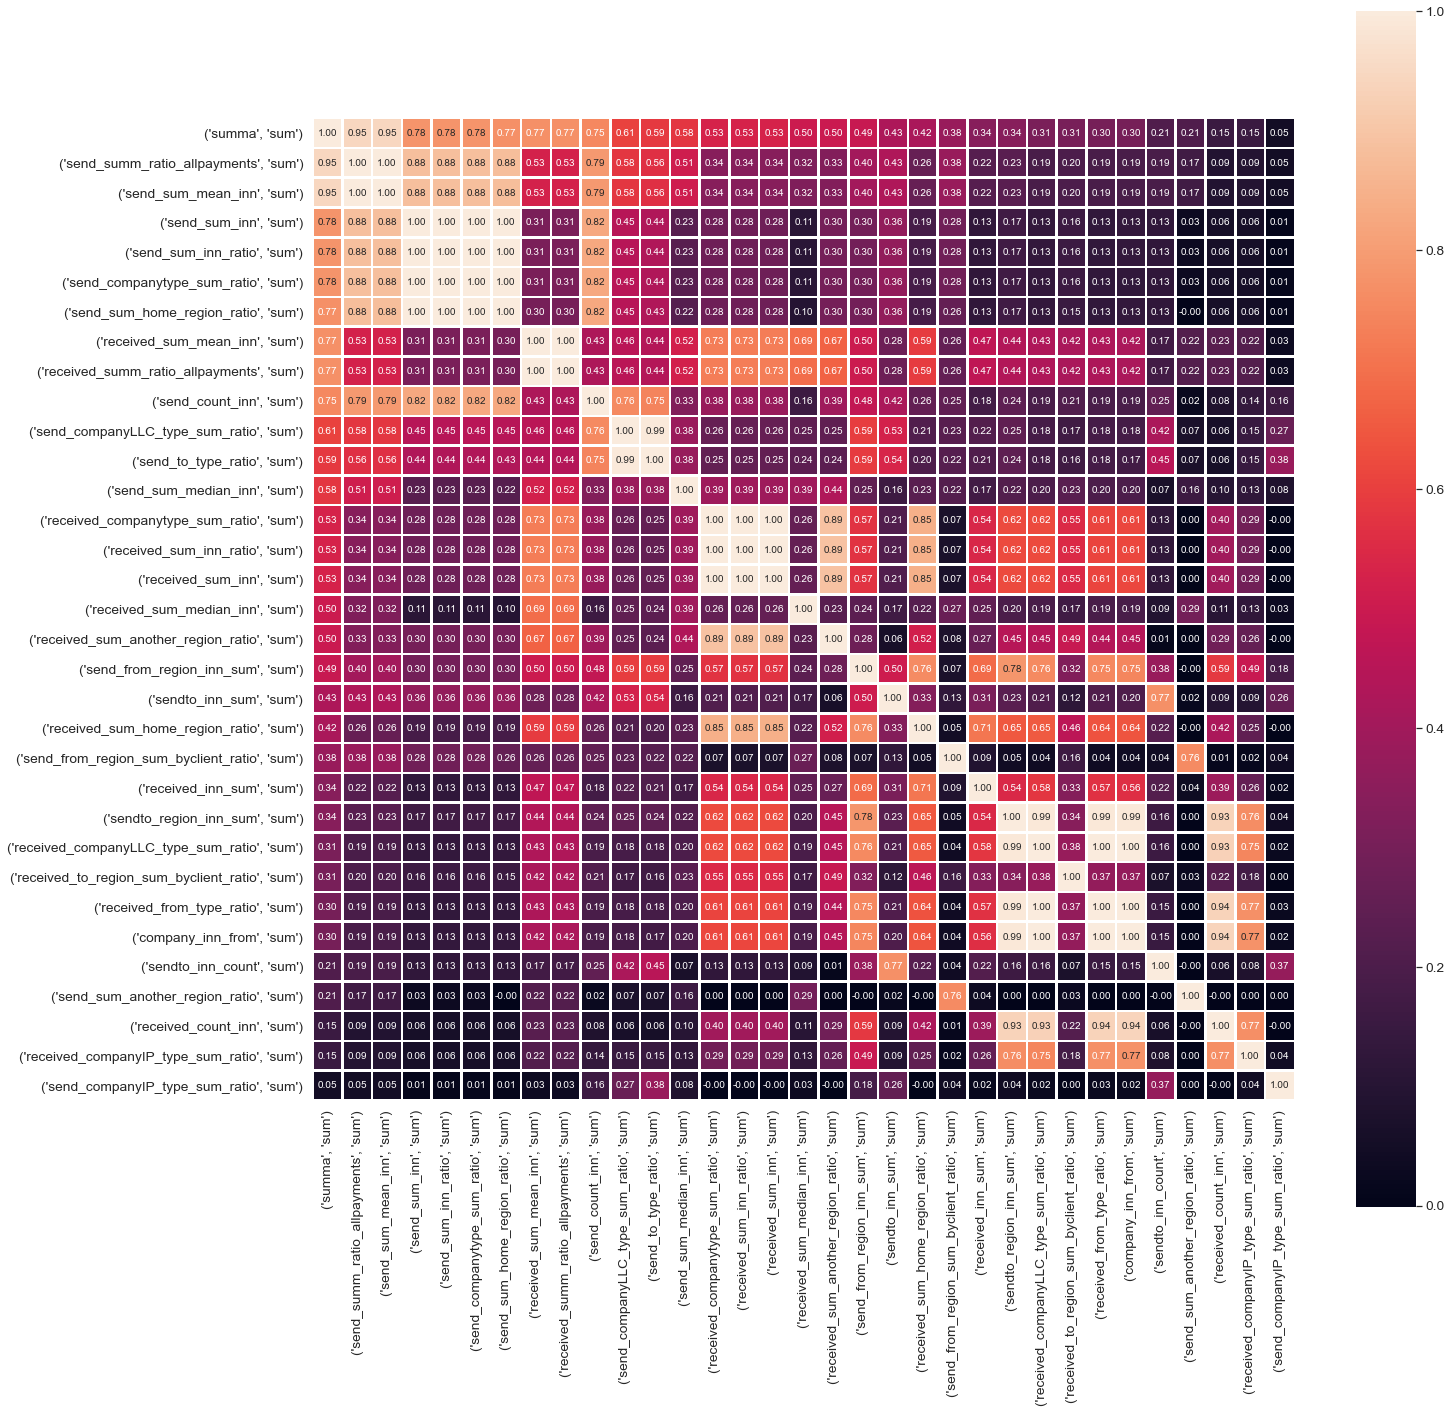

In [101]:
def plot_corr_matrix(df, nr_c, targ) :
    
    corr = df.corr()
    corr_abs = corr.abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=cols.values, xticklabels=cols.values
               )
    plt.show()

target = ('summa', 'sum')
df = stdzed_data_sum

# nr_feats = len(cols_abv_corr_limit)
nr_feats = len(features)
plot_corr_matrix(df, nr_feats, target)

##### Dropping all columns with weak correlation 

In [102]:
# df = stdzed_data_sum
# # to_drop_num  = cols_bel_corr_limit
# # # to_drop_catg = catg_weak_corr

# # cols_to_drop = to_drop_num 

# # for df in [df_train, df_test]:
# df.drop(cols_bel_corr_limit, inplace= True, axis = 1)

#### Correlation Matrix 2 : All features with strong correlation to SalePrice

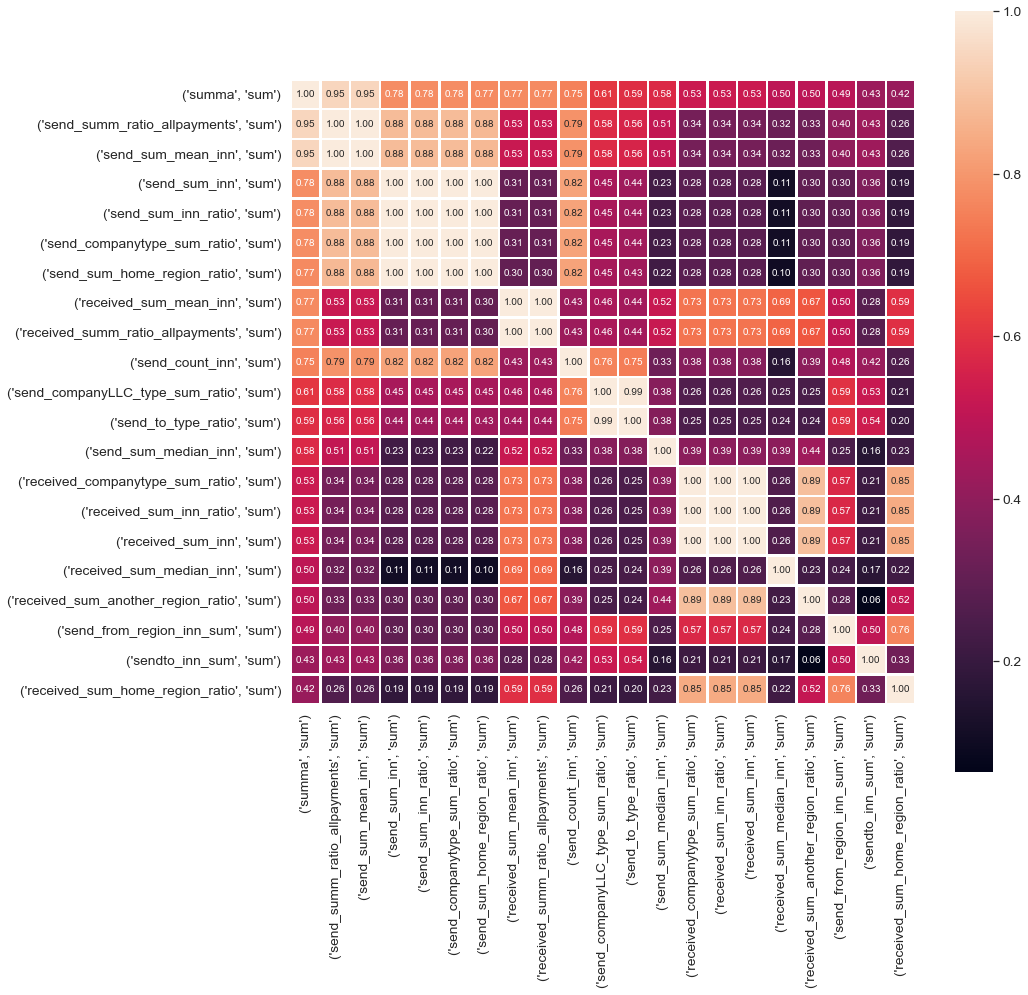

In [103]:
target = ('summa', 'sum')
# df = stdzed_data_sum

nr_feats = len(cols_abv_corr_limit)
plot_corr_matrix(df, nr_feats, target)

## PCA & TSNE

In [104]:
from sklearn.decomposition import PCA # Principal Component Analysis module
from sklearn.manifold import TSNE # TSNE module

In [105]:
data = stdzed_data_sum

# Turn dataframe into arrays
X = data.values
# DataFrame.to_numpy() instead.

# Invoke the PCA method. Since this is a binary classification problem
# let's call n_components = 2
pca = PCA(n_components=2)
pca_2d = pca.fit_transform(X)

# Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results = tsne.fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 28901 samples in 0.001s...
[t-SNE] Computed neighbors for 28901 samples in 20.007s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28901
[t-SNE] Computed conditional probabilities for sample 2000 / 28901
[t-SNE] Computed conditional probabilities for sample 3000 / 28901
[t-SNE] Computed conditional probabilities for sample 4000 / 28901
[t-SNE] Computed conditional probabilities for sample 5000 / 28901
[t-SNE] Computed conditional probabilities for sample 6000 / 28901
[t-SNE] Computed conditional probabilities for sample 7000 / 28901
[t-SNE] Computed conditional probabilities for sample 8000 / 28901
[t-SNE] Computed conditional probabilities for sample 9000 / 28901
[t-SNE] Computed conditional probabilities for sample 10000 / 28901
[t-SNE] Computed conditional probabilities for sample 11000 / 28901
[t-SNE] Computed conditional probabilities for sample 12000 / 28901
[t-SNE] Computed conditional probabilities for s

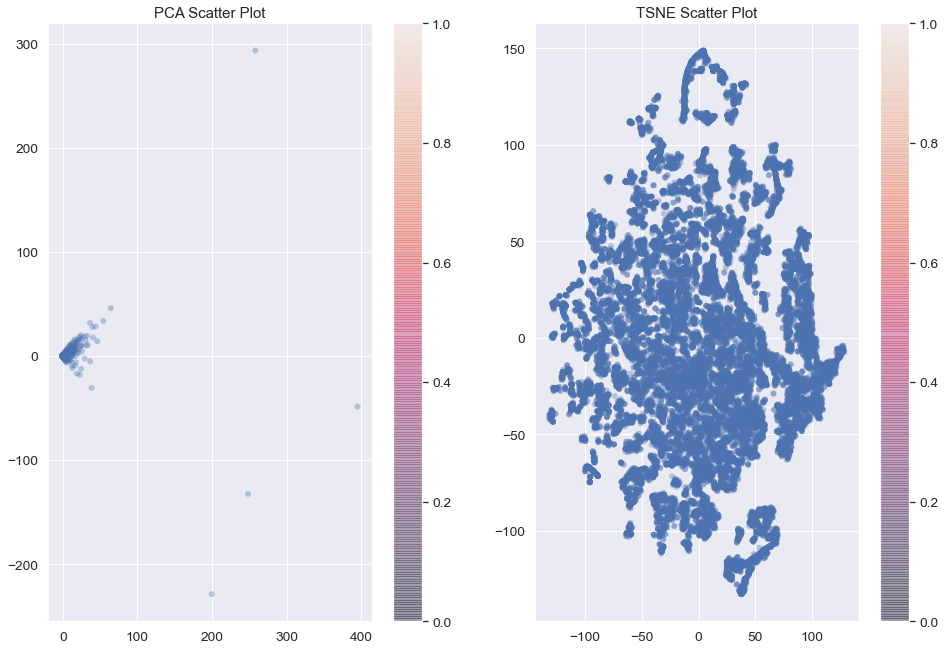

In [106]:
# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (16,11))
plt.subplot(121)
plt.scatter(pca_2d[:,0],pca_2d[:,1],  
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)#c = target,
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(122)
plt.scatter(tsne_results[:,0],tsne_results[:,1],  
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)# c = target
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

#### Определим количество кластеров для TSNE

In [135]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
df = tsne_results

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42,init='k-means++').fit(df)
    k_means.fit(df)
    distortions.append(sum(np.min(cdist(df, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))
    

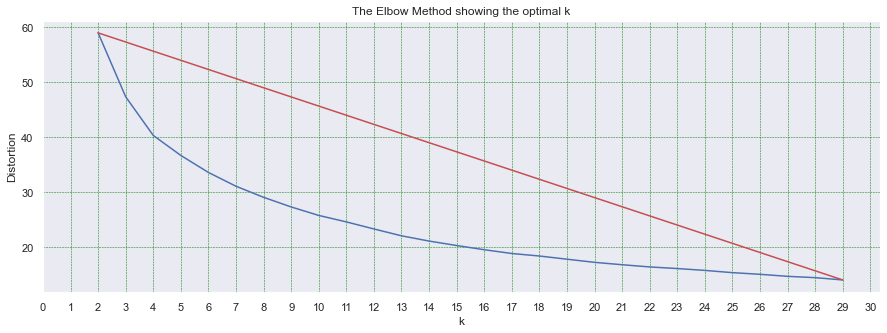

In [136]:
import matplotlib.pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.figure(figsize=(15,5))

plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(np.linspace(0,30,31))
plt.grid(True,color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()


In [137]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
X_scaled = tsne_results
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,30):
    km = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
#     v_measure = v_measure_score(y,preds)
#     vmeasure_score.append(v_measure)
#     print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
#     print("-"*100)
    


Score for number of cluster(s) 2: -122501792.0
Silhouette score for number of cluster(s) 2: 0.3486487865447998
Davies Bouldin score for number of cluster(s) 2: 1.1737436919140702
Score for number of cluster(s) 3: -76271280.0
Silhouette score for number of cluster(s) 3: 0.377810001373291
Davies Bouldin score for number of cluster(s) 3: 0.8659499073610782
Score for number of cluster(s) 4: -54590892.0
Silhouette score for number of cluster(s) 4: 0.37609896063804626
Davies Bouldin score for number of cluster(s) 4: 0.8399480335816005
Score for number of cluster(s) 5: -45881228.0
Silhouette score for number of cluster(s) 5: 0.367336243391037
Davies Bouldin score for number of cluster(s) 5: 0.8622686114572524
Score for number of cluster(s) 6: -38070260.0
Silhouette score for number of cluster(s) 6: 0.3663703501224518
Davies Bouldin score for number of cluster(s) 6: 0.8310333058571692
Score for number of cluster(s) 7: -32383176.0
Silhouette score for number of cluster(s) 7: 0.35854268074035645

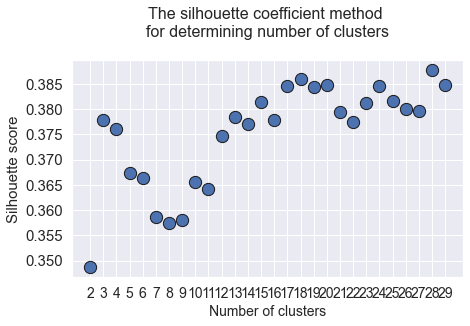

In [138]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,30)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,30)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster, 
# as a different cluster is more similar.

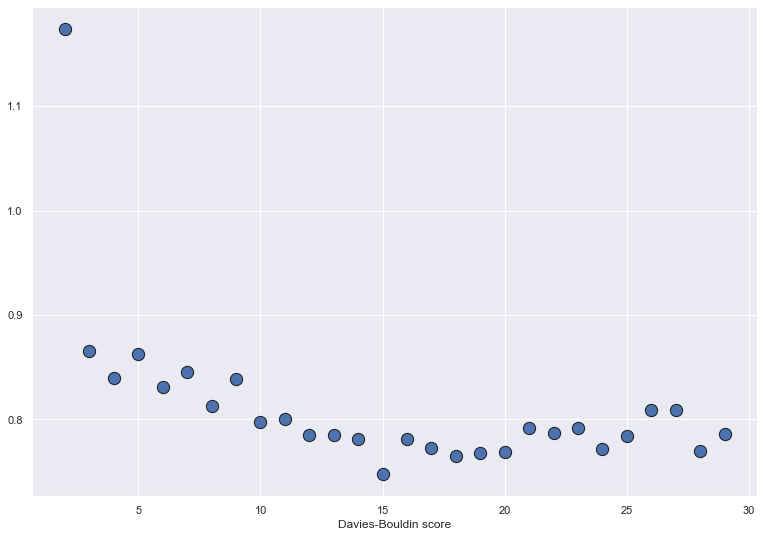

In [139]:
plt.scatter(x=[i for i in range(2,30)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()
# he minimum score is zero, with lower values indicating better clustering.

#### Кластеризуем

In [140]:
k = 15
kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
y_pred = kmeans.fit_predict(tsne_results)
# our_clients_agg_sum['label'] = y_pred


C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


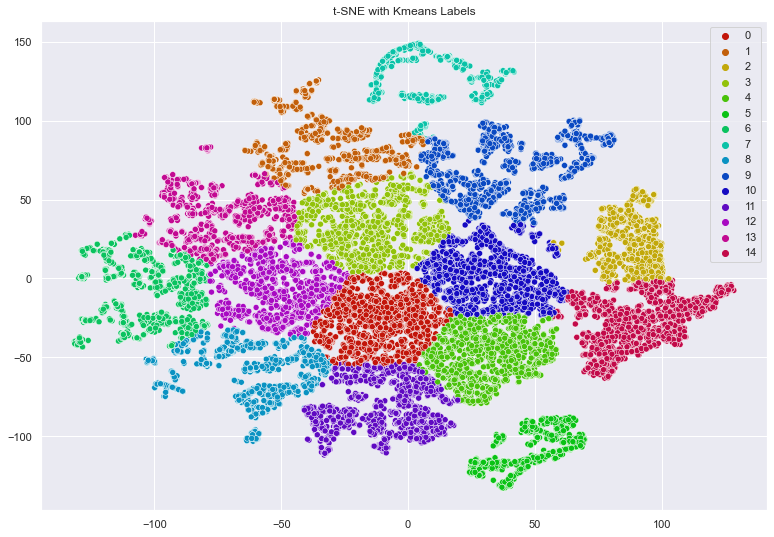

In [141]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(tsne_results[:,0], tsne_results[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

## PCA & TSNE  после StandardScaler

In [116]:
X = our_clients_agg_sum
# Calling Sklearn scaling method
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(X)

In [117]:
# Invoke the PCA method on the standardised data
pca = PCA(n_components=2)
pca_2d_std = pca.fit_transform(X_std)

# Invoke the TSNE method
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=2000)
tsne_results_std = tsne.fit_transform(X_std)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 28901 samples in 0.002s...
[t-SNE] Computed neighbors for 28901 samples in 18.635s...
[t-SNE] Computed conditional probabilities for sample 1000 / 28901
[t-SNE] Computed conditional probabilities for sample 2000 / 28901
[t-SNE] Computed conditional probabilities for sample 3000 / 28901
[t-SNE] Computed conditional probabilities for sample 4000 / 28901
[t-SNE] Computed conditional probabilities for sample 5000 / 28901
[t-SNE] Computed conditional probabilities for sample 6000 / 28901
[t-SNE] Computed conditional probabilities for sample 7000 / 28901
[t-SNE] Computed conditional probabilities for sample 8000 / 28901
[t-SNE] Computed conditional probabilities for sample 9000 / 28901
[t-SNE] Computed conditional probabilities for sample 10000 / 28901
[t-SNE] Computed conditional probabilities for sample 11000 / 28901
[t-SNE] Computed conditional probabilities for sample 12000 / 28901
[t-SNE] Computed conditional probabilities for s

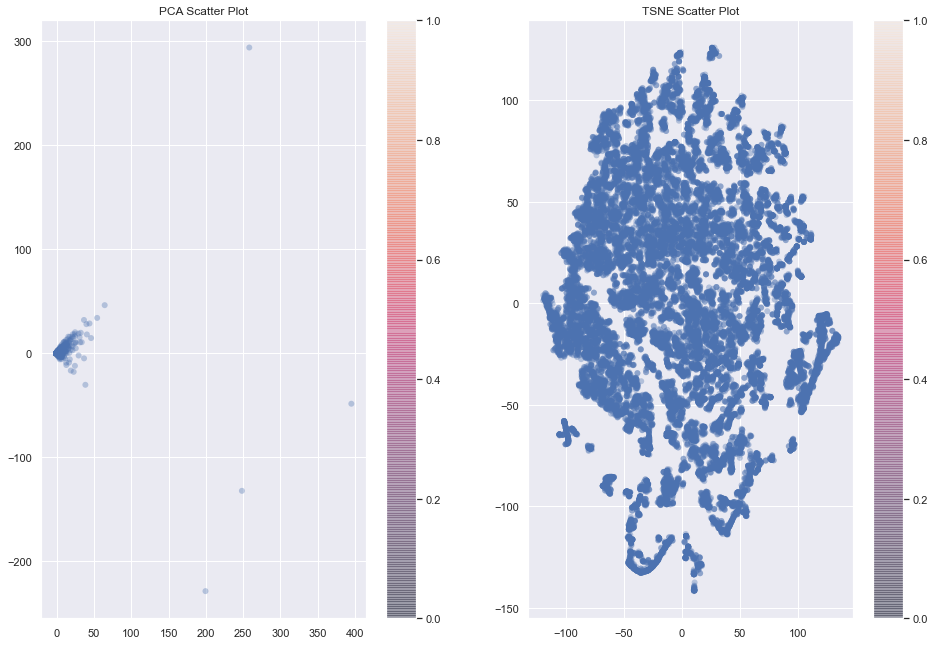

In [118]:
# Plot the TSNE and PCA visuals side-by-side
plt.figure(figsize = (16,11))
plt.subplot(121)
plt.scatter(pca_2d_std[:,0],pca_2d_std[:,1],  
            cmap = "RdYlGn", edgecolor = "None", alpha=0.35)#c = target,
plt.colorbar()
plt.title('PCA Scatter Plot')
plt.subplot(122)
plt.scatter(tsne_results_std[:,0],tsne_results_std[:,1],   
            cmap = "RdYlGn", edgecolor = "None", alpha=0.35)#c = target,
plt.colorbar()
plt.title('TSNE Scatter Plot')
plt.show()

#### Определим количество кластеров

In [122]:
from sklearn import metrics
from scipy.spatial.distance import cdist

# run kmeans with many different k
distortions = []
K = range(2, 30)
for k in K:
    k_means = KMeans(n_clusters=k, random_state=42, init='k-means++').fit(tsne_results_std)
    k_means.fit(tsne_results_std)
    distortions.append(sum(np.min(cdist(tsne_results_std, k_means.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    #print('Found distortion for {} clusters'.format(k))
    

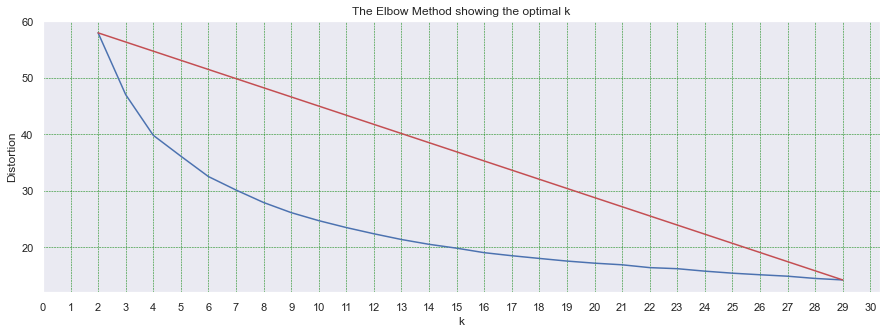

In [123]:
import matplotlib.pyplot as plt

X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# Plot the elbow
plt.figure(figsize=(15,5))

plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(np.linspace(0,30,31))
plt.grid(True,color = 'green', linestyle = '--', linewidth = 0.5)
plt.show()


In [124]:
from sklearn.metrics import silhouette_score, davies_bouldin_score,v_measure_score
X_scaled = tsne_results_std
km_scores= []
km_silhouette = []
vmeasure_score =[]
db_score = []
for i in range(2,30):
    km = KMeans(n_clusters=i, random_state=0, init='k-means++').fit(X_scaled)
    preds = km.predict(X_scaled)
    
    print("Score for number of cluster(s) {}: {}".format(i,km.score(X_scaled)))
    km_scores.append(-km.score(X_scaled))
    
    silhouette = silhouette_score(X_scaled,preds)
    km_silhouette.append(silhouette)
    print("Silhouette score for number of cluster(s) {}: {}".format(i,silhouette))
    
    db = davies_bouldin_score(X_scaled,preds)
    db_score.append(db)
    print("Davies Bouldin score for number of cluster(s) {}: {}".format(i,db))
    
#     v_measure = v_measure_score(y,preds)
#     vmeasure_score.append(v_measure)
#     print("V-measure score for number of cluster(s) {}: {}".format(i,v_measure))
#     print("-"*100)
    


Score for number of cluster(s) 2: -117935968.0
Silhouette score for number of cluster(s) 2: 0.35303908586502075
Davies Bouldin score for number of cluster(s) 2: 1.17239393573513
Score for number of cluster(s) 3: -75460912.0
Silhouette score for number of cluster(s) 3: 0.37012648582458496
Davies Bouldin score for number of cluster(s) 3: 0.8701683770806472
Score for number of cluster(s) 4: -52976180.0
Silhouette score for number of cluster(s) 4: 0.3709696829319
Davies Bouldin score for number of cluster(s) 4: 0.8383451399037953
Score for number of cluster(s) 5: -43825456.0
Silhouette score for number of cluster(s) 5: 0.34415408968925476
Davies Bouldin score for number of cluster(s) 5: 0.9002527474304891
Score for number of cluster(s) 6: -35677464.0
Silhouette score for number of cluster(s) 6: 0.3681390583515167
Davies Bouldin score for number of cluster(s) 6: 0.8443696818395976
Score for number of cluster(s) 7: -30517650.0
Silhouette score for number of cluster(s) 7: 0.36370187997817993


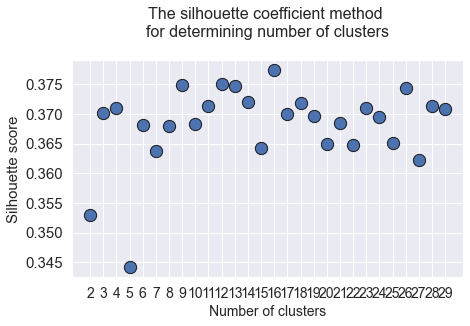

In [125]:
plt.figure(figsize=(7,4))
plt.title("The silhouette coefficient method \nfor determining number of clusters\n",fontsize=16)
plt.scatter(x=[i for i in range(2,30)],y=km_silhouette,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Number of clusters",fontsize=14)
plt.ylabel("Silhouette score",fontsize=15)
plt.xticks([i for i in range(2,30)],fontsize=14)
plt.yticks(fontsize=15)
plt.show()

# The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters.
# Negative values generally indicate that a sample has been assigned to the wrong cluster, 
# as a different cluster is more similar.

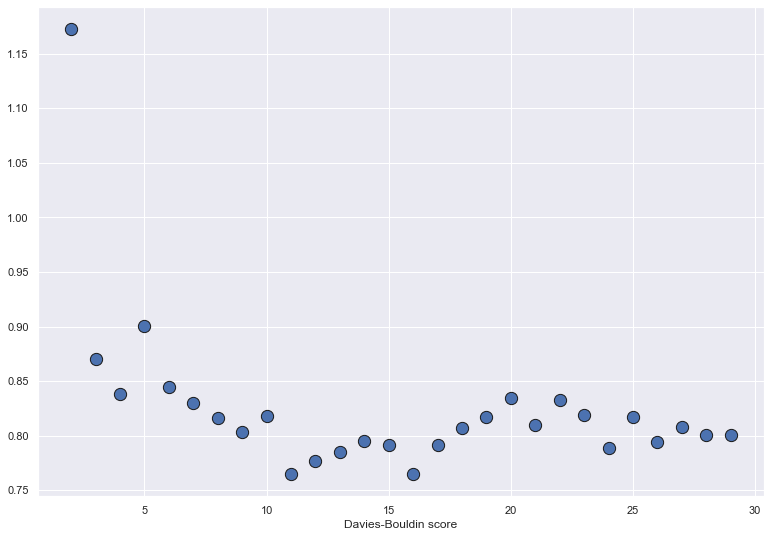

In [126]:
plt.scatter(x=[i for i in range(2,30)],y=db_score,s=150,edgecolor='k')
plt.grid(True)
plt.xlabel("Davies-Bouldin score")
plt.show()
# the minimum score is zero, with lower values indicating better clustering.

In [ ]:
# tsne_results_std

#### Кластеризуем

In [129]:
k = 16
kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
y_pred = kmeans.fit_predict(tsne_results_std)
our_clients_agg_sum['label'] = y_pred


C:\Users\alexl\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


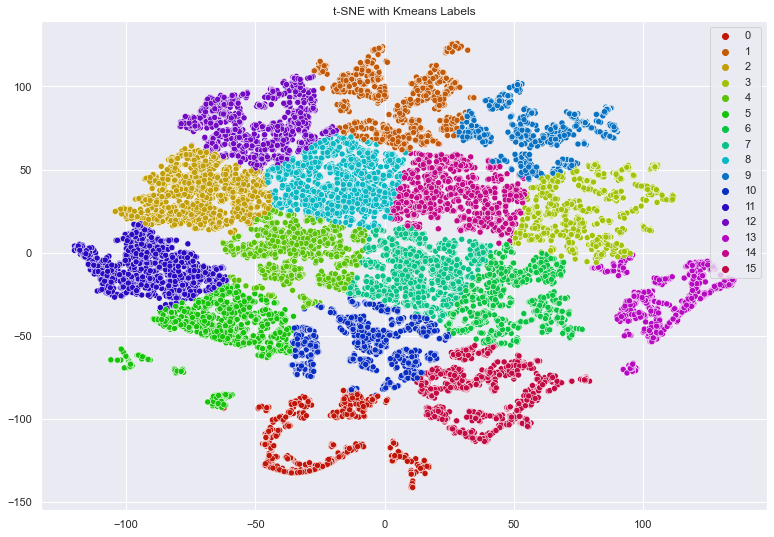

In [130]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

# sns settings
sns.set(rc={'figure.figsize':(13,9)})

# colors
palette = sns.hls_palette(k, l=.4, s=.9)

# plot
sns.scatterplot(tsne_results_std[:,0], tsne_results_std[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
# plt.savefig("improved_cluster_tsne.png")
plt.show()

In [131]:
our_clients_agg_sum.label.value_counts()

2     2047
8     1969
7     1959
1     1935
3     1913
11    1897
5     1880
12    1875
15    1868
6     1803
14    1761
4     1724
10    1716
0     1558
13    1519
9     1477
Name: label, dtype: int64

In [ ]:
# our_clients_agg_sum.columns

In [134]:
our_clients_agg_sum.groupby(['label']).agg([sum, min, max,'mean','median'])

summa                                               \
               sum                                                
               sum    min         max          mean      median   
label                                                             
0        120356263      0     1005581  7.725049e+04     18999.0   
1       1020740095     18    19646640  5.275143e+05    179652.0   
2      72756502240   2573  7493910970  3.554299e+07   7101350.0   
3        403882338     10    14832706  2.111251e+05     65650.0   
4      86877595819  31452  2373987820  5.039304e+07  17403044.0   
5       2261325535      1    33619600  1.202833e+06    382587.0   
6        489484328      2     5552792  2.714833e+05     75930.0   
7       4036584266   1306    35570608  2.060533e+06    881912.0   
8       7958242507   4720    71131908  4.041769e+06   2220954.0   
9        725360939     58     9060362  4.911042e+05    125210.0   
10      1619417105     58    21706302  9.437163e+05    366758.5   
11     11071200607  13886   714711312  5.836163e+06   2171692.0   
12      3468603484    373    45586482  1.849922e+06    715230.0   
13       181928909      0     1099986  1.197689e+05     59700.0   
14      1921483684   3670    11270014  1.091132e+06    578262.0   
15       414899830      0     2511672  2.221091e+05     62549.0   

      send_summ_ratio_allpayments                                              \
                              sum                                               
                              sum           min       max      mean    median   
label                                                                           
0                        0.079379  0.000000e+00  0.000974  0.000051  0.000010   
1                        0.899196  2.470465e-08  0.026965  0.000465  0.000127   
2                       68.108213  3.531393e-06  9.954022  0.033272  0.006392   
3                        0.325085  1.372481e-08  0.017233  0.000170  0.000047   
4                       66.304485  0.000000e+00  2.017547  0.038460  0.008774   
5                        1.964728  1.372481e-09  0.037651  0.001045  0.000327   
6                        0.326942  0.000000e+00  0.007432  0.000181  0.000049   
7                        2.833569  0.000000e+00  0.048531  0.001446  0.000476   
8                        7.047303  6.478109e-06  0.097627  0.003579  0.001616   
9                        0.427120  7.960389e-08  0.007459  0.000289  0.000078   
10                       0.895848  0.000000e+00  0.019478  0.000522  0.000053   
11                      10.421796  1.905827e-05  0.876959  0.005494  0.002024   
12                       2.806812  5.119353e-07  0.033975  0.001497  0.000550   
13                       0.007653  0.000000e+00  0.000375  0.000005  0.000000   
14                       1.448305  3.634329e-06  0.014403  0.000822  0.000375   
15                       0.348712  0.000000e+00  0.002750  0.000187  0.000041   

       ... received_companyIP_type_sum_ratio                                  \
       ...                               sum                                   
       ...                               sum  min            max        mean   
label  ...                                                                     
0      ...                      5.514965e+02  0.0     100.000000    0.353977   
1      ...                      1.550808e+04  0.0     458.074355    8.014513   
2      ...                      5.003213e+05  0.0  177059.919118  244.416834   
3      ...                      4.978535e+03  0.0     351.448142    2.602475   
4      ...                      1.414325e+06  0.0   95113.998740  820.373975   
5      ...                      5.397783e+04  0.0    1379.360962   28.711609   
6      ...                      1.679519e+04  0.0     434.369527    9.315137   
7      ...                      4.972199e+04  0.0     772.735085   25.381312   
8      ...                      8.506068e+04  0.0    1278.552296   43.199938   
9      ... 